In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import warnings
import optuna

from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from catboost import CatBoostRegressor

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from tpot import TPOTRegressor

from phik import phik_matrix, significance_matrix

from prophet import Prophet

In [2]:
RANDOM_STATE = 654321
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

scaler_dict = {
    'None': None,
    'StandardS': StandardScaler(),
    'MinMaxS': MinMaxScaler(),
    'RobustS': RobustScaler(),
    'MaxAbsS': MaxAbsScaler()
}
warnings.filterwarnings('ignore')

In [3]:
def bas_stat_num_feat_(df: pd.Series, xlab: str=None, bins: int=None, log=False) -> plt:
    '''
    Гистограмма + оценка плотности распределения + диаграмма размаха + базовые статистики
    '''
    df = df.copy(deep=True)
    if log:
        df = np.log1p(df)

    if bins == None:
        bins=int((5*np.log2(len(df))))

    _ = plt.figure(figsize=(6, 3))
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 

    ax0 = plt.subplot(gs[0]) # График distplot
    df.hist(density=True, ax=ax0, bins=bins, color='#77AADD', edgecolor='black', linewidth=0.5)
    df.plot(kind='kde', linewidth=1, color='red')
    ax0.set_xlabel('')
    ax0.set_ylabel('Плотность вероятностей')
    ax0.set_title(f'Статистика распределения признака \'{df.name}\'')

    ax1 = plt.subplot(gs[1]) # Горизонтальный boxplot
    sns.boxplot(x=df, ax=ax1, orient='h', color='#77AADD', 
        boxprops=dict(edgecolor='black', linewidth=0.5),
        whiskerprops=dict(color='black', linewidth=0.5),
        capprops=dict(color='black', linewidth=0.5),
        medianprops=dict(color='black', linewidth=0.5)
    )
    ax1.set_xlabel(xlab)
    ax1.set_ylabel('')

    ax0.set_xlim([np.min(df),np.max(df)])
    ax1.set_xlim([np.min(df),np.max(df)])
    plt.tight_layout()

    def t_st_(len):
        t_st = {600: 3.5, 350:3.4, 175:3.3, 125:3.2, 105:3.1, 85:3.0, 67:2.9, 47:2.8, 35:2.7, 29:2.6, 21:2.5, 16:2.4, 10:2.3, 5:2.2, 3:2.1, 2:2.0}
        for t, n in t_st.items():
            if len >= t:
                return n

    q_01, q_25, q_50, q_75, q_99 = np.quantile(df, .01), np.quantile(df, .25), np.quantile(df, .50), np.quantile(df, .75), np.quantile(df, .99)
    truncated_std = np.std(np.sort(np.array(df))[int(len(df)*0.05):int(len(df)*0.95)], ddof=1)
    emissions_iqr = len(df[(df < (q_25 - 1.5 * (q_75 - q_25)))|(df > (q_75 + 1.5 * (q_75 - q_25)))])
    emissions_tst = sum(((np.array(df) - np.mean(df)) / np.std(df)) > t_st_(df.count()))

    text_x = ((ax0.get_xlim()[1] - ax0.get_xlim()[0]) * 0.02) + ax0.get_xlim()[1]
    text_y = -0.3
    plt.text(text_x, text_y-6.0, f'Выборочное среднее: {np.mean(df):.2f}')
    plt.text(text_x, text_y-5.5, f'Усечённое среднее на 10%: {st.trim_mean(df, 0.1):.2f}')
    plt.text(text_x, text_y-5.0, f'25, 50, 75 процентиль: {q_01:.2f}, {q_25:.2f}, {q_50:.2f}, {q_75:.2f}, {q_99:.2f}')
    plt.text(text_x, text_y-4.5, f'Выборочное std: {np.std(df, ddof=1):.2f}')
    plt.text(text_x, text_y-4.0, f'Выборочное std на основе усеченной средней: {truncated_std:.2f}')
    plt.text(text_x, text_y-3.5, f'Минимальное значение: {np.min(df):.2f}')
    plt.text(text_x, text_y-3.0, f'Максимальное значение: {np.max(df):.2f}')
    plt.text(text_x, text_y-2.5, f'Эксцесс: {df.kurt():.2f}')
    plt.text(text_x, text_y-2.0, f'Коэффициент асимметрии: {df.skew():.2f}')
    plt.text(text_x, text_y-1.5, f'Количество наблюдений: {df.count()}')
    plt.text(text_x, text_y-1.0, f'Количество уникальных значений: {df.nunique()}')
    plt.text(text_x, text_y-0.5, f'Количество выбрасов по (IQR) критерию: {emissions_iqr}')
    plt.text(text_x, text_y-0.0, f'Количество выбрасов по Тst критерию: {emissions_tst}')
    plt.show()

def plot_box_diagram_and_MW_test_(df: pd.DataFrame, num_feat: str, cat_feat: str, x_title: str = None, y_title: str = None, title: str = None) -> plt:

    _, ax = plt.subplots(figsize=((2+1*df[cat_feat].nunique()), 3))
    
    # Вычисление медианы для каждой категории
    order = list(df.groupby(cat_feat)[num_feat].median().sort_values().index)
    
    sns.boxplot(x=cat_feat, y=num_feat, data=df, ax=ax, orient='v', color='#77AADD', 
        boxprops=dict(edgecolor='black', linewidth=0.5),
        whiskerprops=dict(color='black', linewidth=0.5),
        capprops=dict(color='black', linewidth=0.5),
        medianprops=dict(color='black', linewidth=0.5),
        order=order  # Отсортированный список категорий
    )
    sns.stripplot(x=cat_feat, y=num_feat, data=df, ax=ax, orient='v', color='red', size=2, order=order)

    if title == None:
        title=f'Ящечная диаграмма признака \'{cat_feat}\' по признаку \'{num_feat}\''
    if x_title == None:
        x_title='Категориальный признак'
    if y_title == None:
        y_title='Числовой признак'

    ax.set_title(title)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)

    plt.show()

    # Тест Манна-Уитни для каждой пары классов
    classes = df[cat_feat].unique()
    results = []
    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):
            class1 = classes[i]
            class2 = classes[j]
            
            data1 = df[df[cat_feat] == class1][num_feat].dropna()
            data2 = df[df[cat_feat] == class2][num_feat].dropna()

            if not data1.empty and not data2.empty:
                stat, p_value = st.mannwhitneyu(data1, data2) # Тест Манна-Уитни
                results.append({'Class1': class1, 'Class2': class2, 'p-value': np.round(p_value, 2)})

    display(pd.DataFrame(results).sort_values(by=['p-value','Class1','Class2']))

def investigating_data_gaps_(df, cols=[]):

    if cols != []:
        df = df[cols].copy()
    
    plt.figure(figsize=(int(np.round(df.shape[1]/4)), 3))

    ax = df.isnull().sum().sort_values(ascending=False).plot(kind='bar', edgecolor='black', linewidth=0.5, color='purple', alpha=0.5)
    [ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 15), textcoords='offset points', rotation=90) for p in ax.patches]
    
    plt.title('Пропуски в данных')
    plt.show()

def plotting_the_phik_correlation_(df, feature_num=[], feature_bin=[], feature_cat=[], target='target') -> None:
    '''
    Построение матрицы корреляций PhiK и матрицы значимости корреляций для таргета

    Параметры:
    df (pd.DataFrame): Исходный DataFrame.
    feature_num (list, необязательный): Список числовых признаков.
    feature_bin (list, необязательный): Список бинарных признаков.
    feature_cat (list, необязательный): Список категориальных признаков.
    target (str, необязательный): Название целевого признака. По умолчанию 'target'.

    Возвращает:
    None: Функция отображает графики и не возвращает значения.
    '''
    feature_for_phik = feature_num + feature_bin + feature_cat + [target]

    # Расчет корреляционной матрицы PhiK
    phik_matrix = df[feature_for_phik].phik_matrix(interval_cols=feature_num+[target])
    mask = np.triu(np.ones_like(phik_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(0.6 + (0.6 * len(phik_matrix)), 0.3 + (0.3 * len(phik_matrix))))
    sns.heatmap(phik_matrix, mask=mask, vmin=0, vmax=0.5, square=True, annot=True, fmt='.2f', cmap='Purples', annot_kws={"size": 7})
    plt.title('Матрица коэффициентов PhiK')
    plt.show()

    # Расчет матрицы значимости корреляций PhiK
    signif_matrix = df[feature_for_phik].significance_matrix(interval_cols=feature_num+[target])
    filtered_signif_matrix = signif_matrix.loc[[target], feature_for_phik]
    plt.figure(figsize=(0.5 + (0.5 * len(signif_matrix)), 0.4))
    sns.heatmap(filtered_signif_matrix, vmin=-5, vmax=5, annot=True, cmap='Purples', annot_kws={"size": 7}, fmt='.2f')
    plt.title('Матрица значимости коэффициентов PhiK для таргета')
    plt.show()

## **1. Загрузка и исследование данных**

In [4]:
# Загрузка данных
beer_sales = pd.read_parquet('beer_sales_data.parquet')
cig_sales = pd.read_parquet('cig_sales_data.parquet')
ana_sales = pd.read_parquet('ana_sales_data.parquet')
demographic_data = pd.read_parquet('demographic_data.parquet')
beer_upc = pd.read_parquet('beer_upc.parquet')
cig_upc = pd.read_parquet('cig_upc.parquet')
ana_upc = pd.read_parquet('ana_upc.parquet')

# Объединение данных продаж с данными UPC
beer_sales = beer_sales.merge(beer_upc, on='upc', how='left')
cig_sales = cig_sales.merge(cig_upc, on='upc', how='left')
ana_sales = ana_sales.merge(ana_upc, on='upc', how='left')

# Объединение данных продаж с демографическими данными
beer_sales_dem = beer_sales.merge(demographic_data, on='store', how='left')
cig_sales_dem = cig_sales.merge(demographic_data, on='store', how='left')
ana_sales_dem = ana_sales.merge(demographic_data, on='store', how='left')

Данная задача представляет собой анализ временного ряда с целью прогнозирования спроса на основе исторических данных. Логично предположить, что, опираясь на имеющуюся информацию, можно спрогнозировать продажи на следующую неделю, используя данные предыдущей. Поскольку задача упрощена, выполним прогноз для трёх категорий товаров.

move     price     age60      age9      educ    ethnic     income  \
week                                                                        
91     58515  5.316748  0.173408  0.140748  0.215431  0.149686  10.618265   
92     70570  5.309555  0.174062  0.139949  0.216726  0.152439  10.606642   
93     69579  5.202625  0.173863  0.139942  0.216956  0.141225  10.616302   
94     70108  5.040070  0.173579  0.140090  0.216569  0.142961  10.613529   
95    100298  5.139562  0.173486  0.140270  0.216257  0.156115  10.604627   

       hhlarge   workwom   hval150  sstrdist   sstrvol   cpdist5   cpwvol5  \
week                                                                         
91    0.120199  0.354972  0.325836  5.047731  1.155433  2.205654  0.416768   
92    0.118739  0.355435  0.332325  5.075933  1.174905  2.178141  0.423485   
93    0.119019  0.355906  0.334287  4.883118  1.170503  2.190332  0.427292   
94    0.119173  0.356092  0.332827  4.916809  1.170219  2.190045  0.425359   
95    0.119130  0.355205  0.331134  5.119309  1.178579  2.175543  0.421194   

        sale_B  sale_S  sale_C  store  
week                                   
91    0.185256     0.0     0.0     64  
92    0.184930     0.0     0.0     65  
93    0.258914     0.0     0.0     65  
94    0.196081     0.0     0.0     65  
95    0.174063     0.0     0.0     66

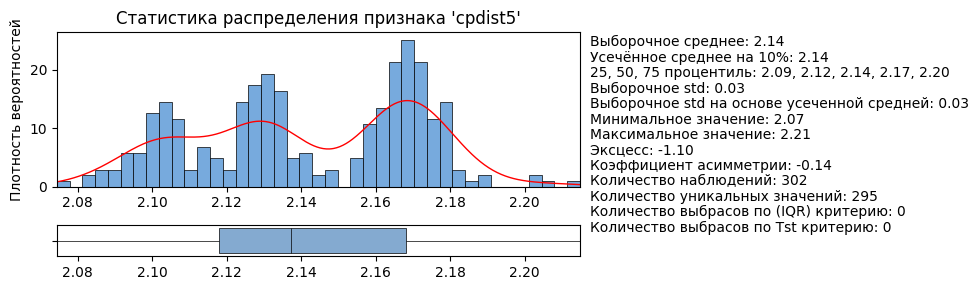

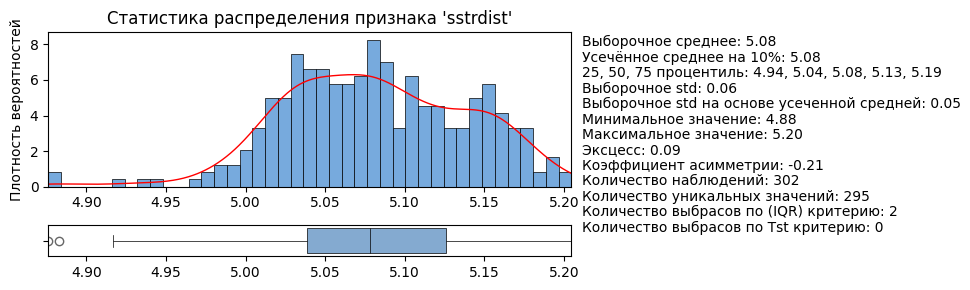

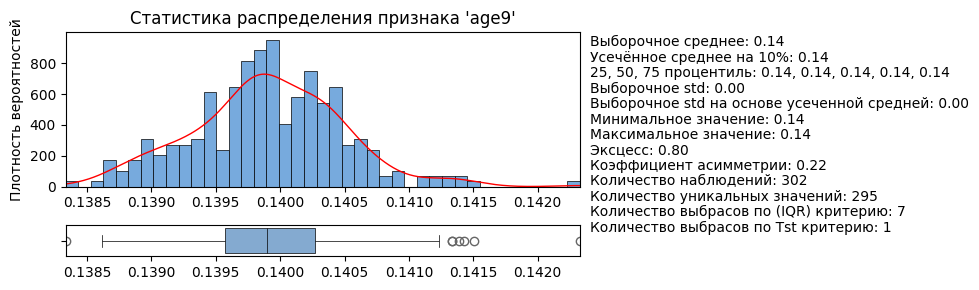

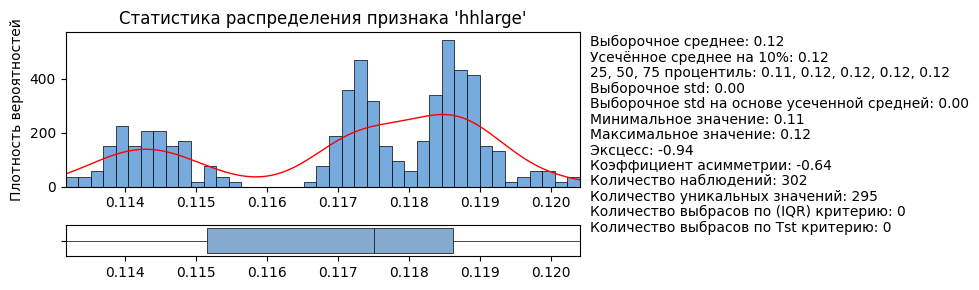

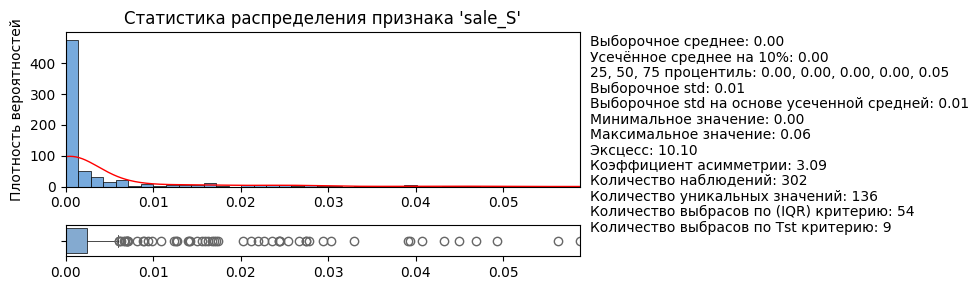

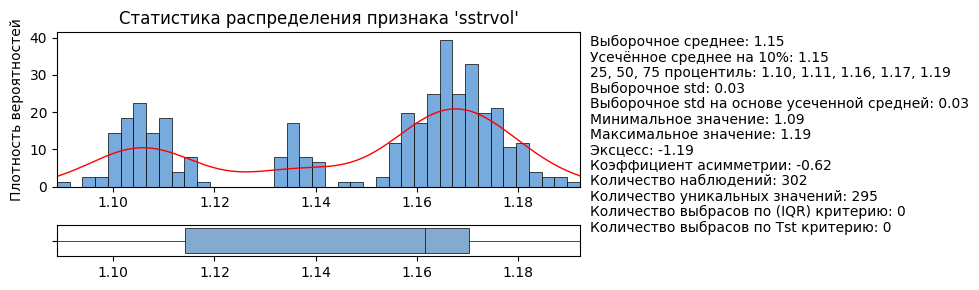

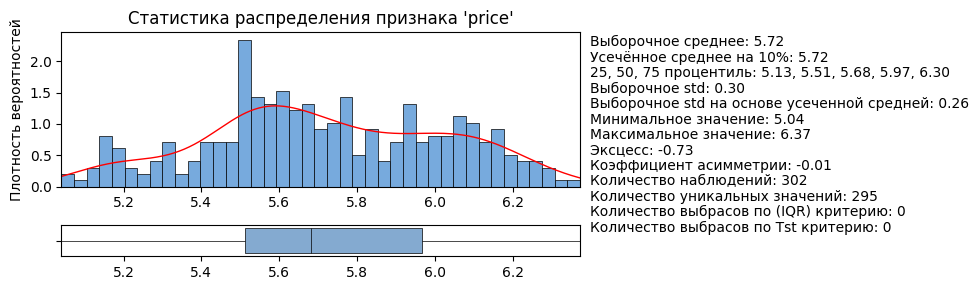

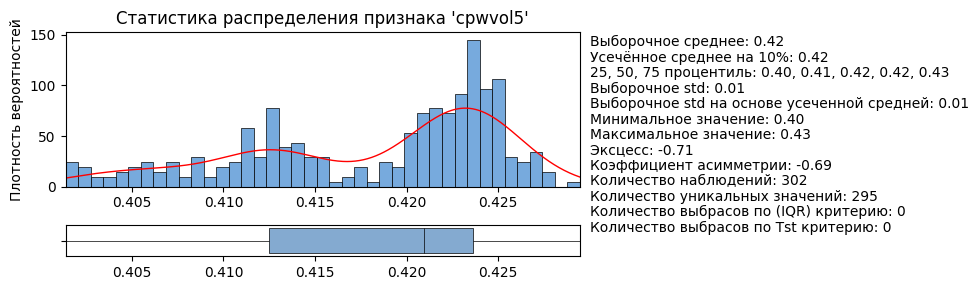

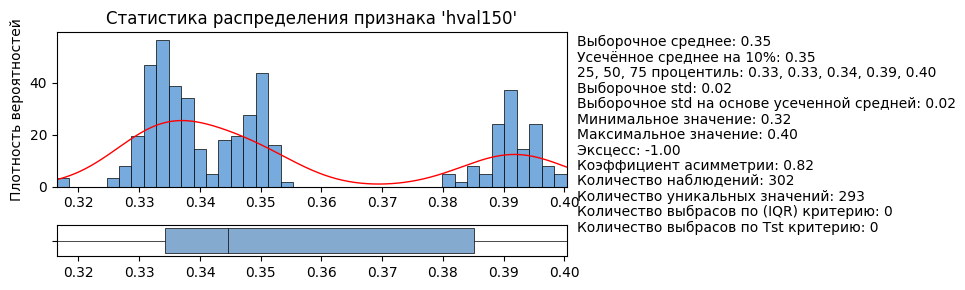

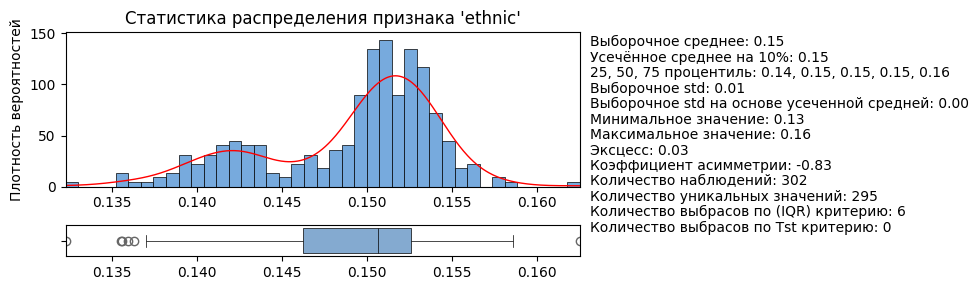

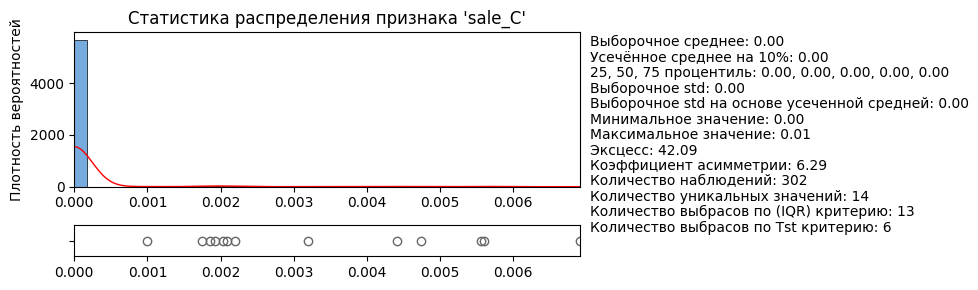

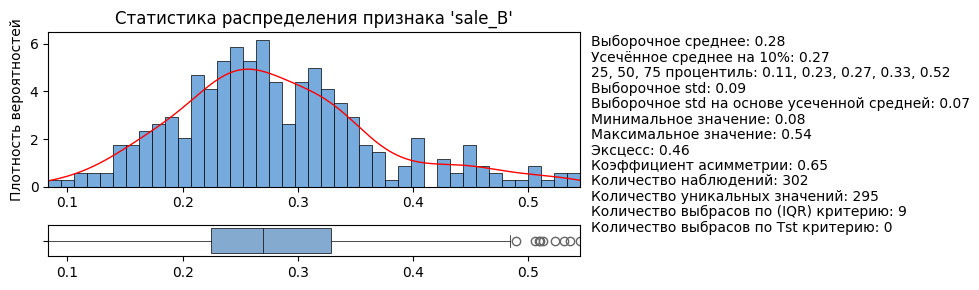

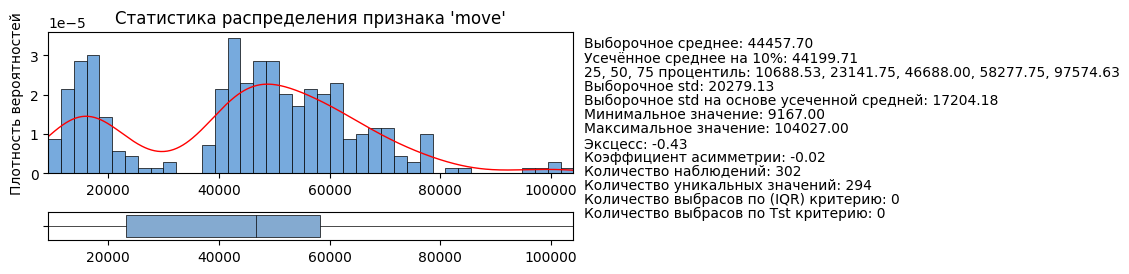

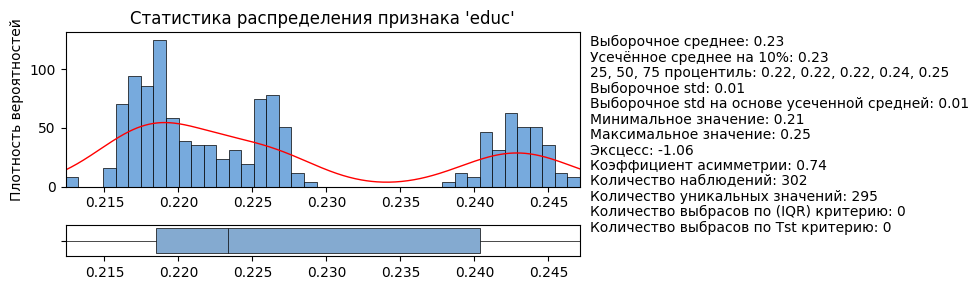

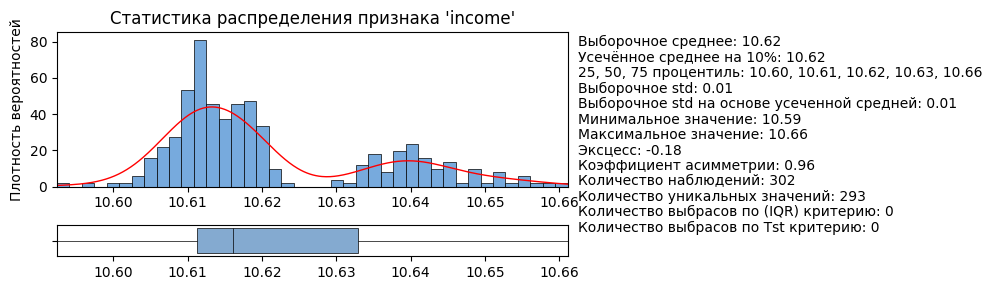

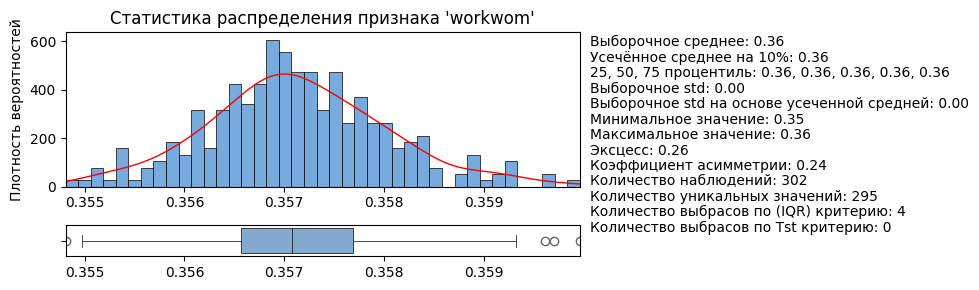

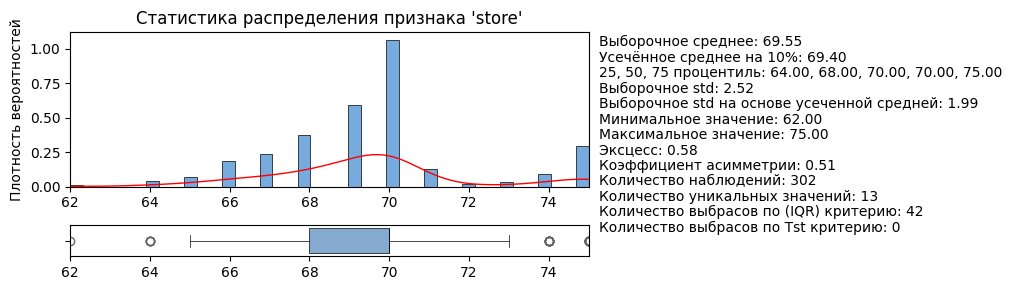

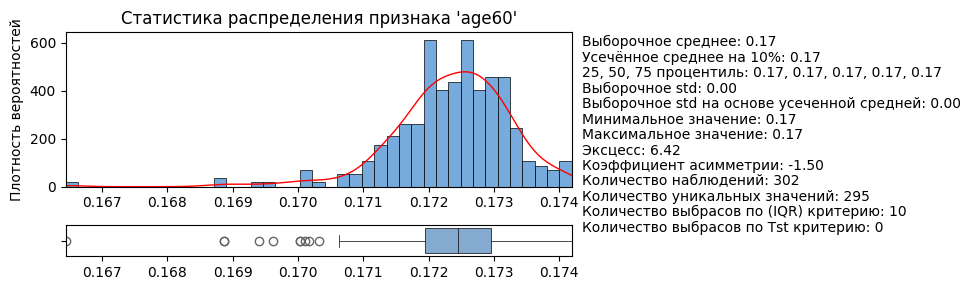

In [5]:
# Исследование beer_sales_dem
# Преобразование категориального признака в бинарные признаки 
beer_sales_dem['sale_B'] = (beer_sales_dem['sale'] == 'B').astype(int)
beer_sales_dem['sale_S'] = (beer_sales_dem['sale'] == 'S').astype(int)
beer_sales_dem['sale_C'] = (beer_sales_dem['sale'] == 'C').astype(int)

# Оставляем более менее информативные фили
beer_sales_dem = beer_sales_dem.drop(columns=['upc','descrip','size','nitem','case','qty','sale'])
beer_sales_dem = beer_sales_dem[beer_sales_dem['price'] != 0] # Очень много товаров с нулевой ценой, не ясно с чем это связано, ощущение что это просроченый или списанный товар

# Групируем данные по неделям
beer_sales_weekly = beer_sales_dem.groupby(['week']).agg({'move': 'sum', 'price': 'mean', 'age60': 'mean', 'age9': 'mean', 'educ': 'mean', 'ethnic': 'mean', 'income': 'mean', 'hhlarge': 'mean',
    'workwom': 'mean', 'hval150': 'mean', 'sstrdist': 'mean', 'sstrvol': 'mean', 'cpdist5': 'mean', 'cpwvol5': 'mean', 'sale_B': 'mean', 'sale_S': 'mean', 'sale_C': 'mean', 'store': 'nunique'}).dropna().sort_index()

display(beer_sales_weekly.head())

# Оcновные статистики числовых признаков
num_cols = list(set(beer_sales_weekly.select_dtypes(include=[np.number]).columns))
beer_sales_weekly[num_cols].describe().round(2).transpose().sort_index()

for col in num_cols:
    bas_stat_num_feat_(df=beer_sales_weekly[col], log=False)

move     price     age60      age9      educ    ethnic     income  \
week                                                                       
1     90164  6.380581  0.169211  0.138113  0.233780  0.125638  10.652717   
2     88266  6.365139  0.168380  0.138845  0.232597  0.126560  10.652346   
3     86558  6.190177  0.166918  0.139577  0.231597  0.133256  10.647768   
4     90873  6.015495  0.164913  0.140070  0.230745  0.127453  10.650691   
5     91442  6.063626  0.165185  0.140273  0.231058  0.125866  10.652646   

       hhlarge   workwom   hval150  sstrdist   sstrvol   cpdist5   cpwvol5  \
week                                                                         
1     0.114854  0.365069  0.361262  4.315121  1.161859  2.145290  0.454093   
2     0.115356  0.365605  0.355621  4.467961  1.156822  2.187910  0.453044   
3     0.116076  0.366001  0.352871  4.398788  1.156238  2.178297  0.459455   
4     0.116130  0.367965  0.350542  4.458195  1.171858  2.160079  0.456977   
5     0.116557  0.366651  0.349983  4.413249  1.183471  2.140024  0.453814   

      sale_B  sale_S  sale_C  store  
week                                 
1          0       0       0     71  
2          0       0       0     69  
3          0       0       0     71  
4          0       0       0     73  
5          0       0       0     74

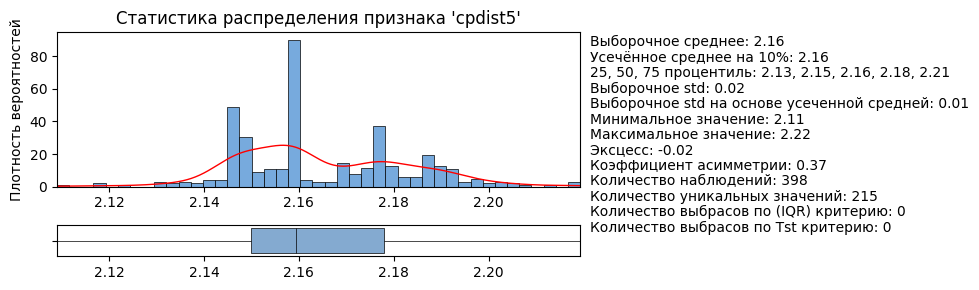

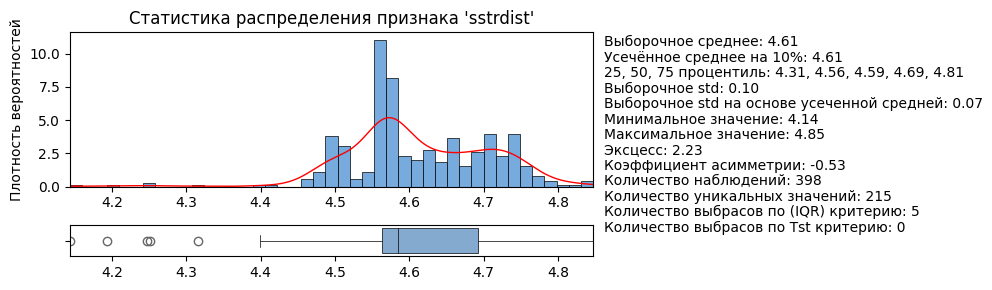

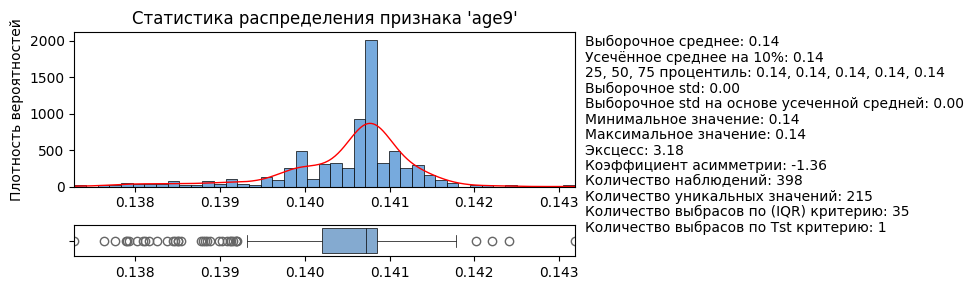

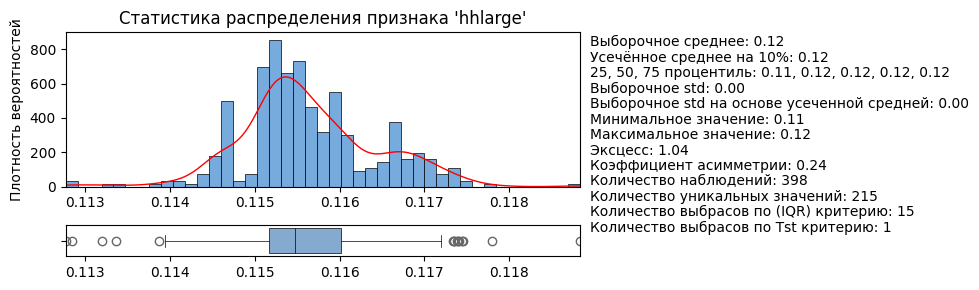

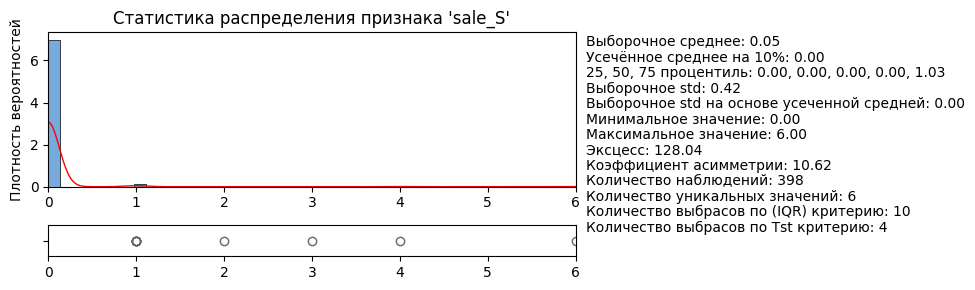

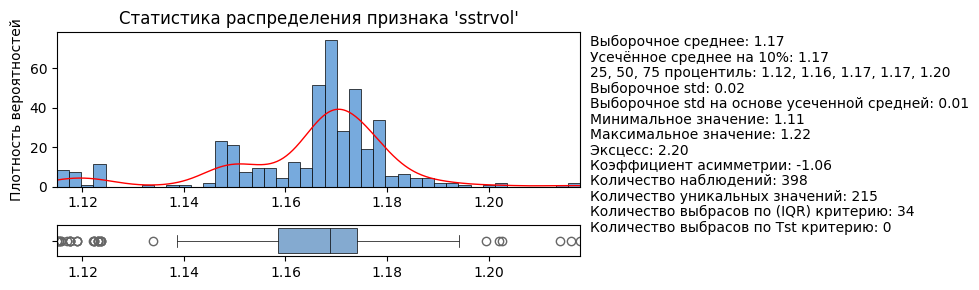

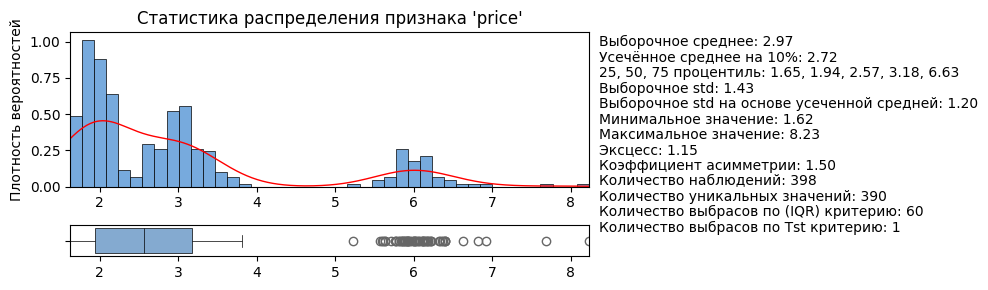

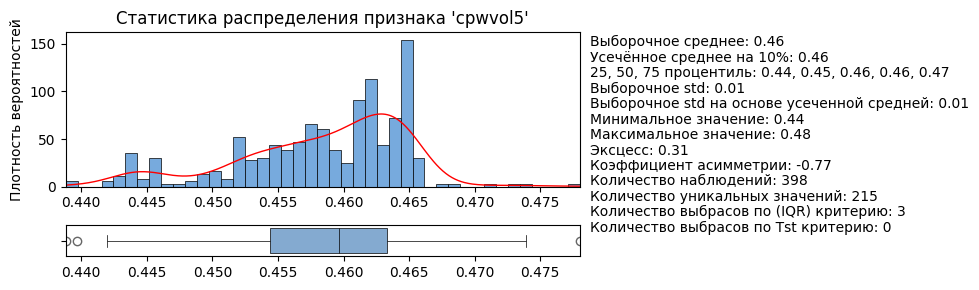

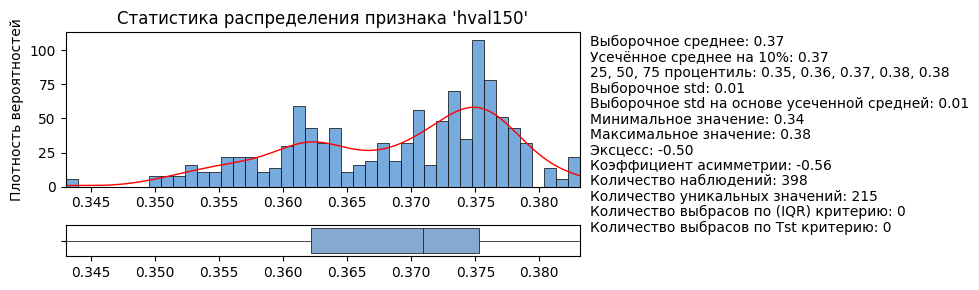

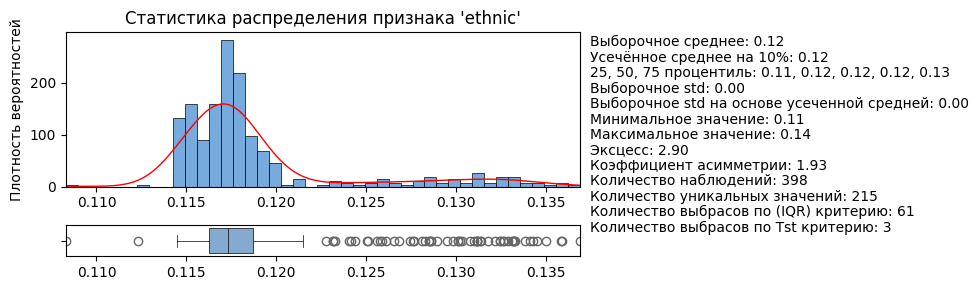

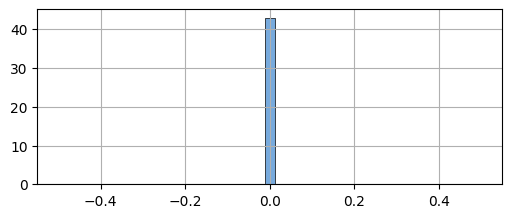

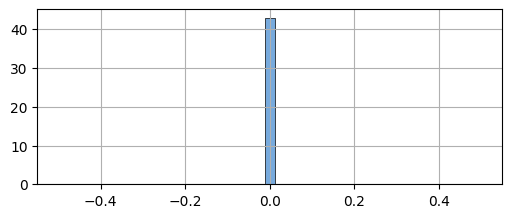

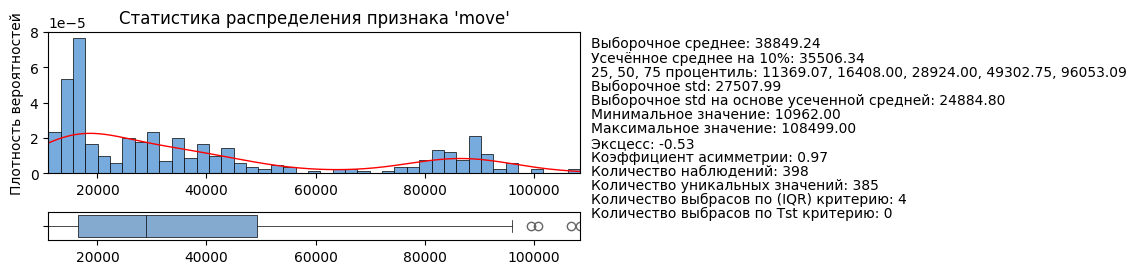

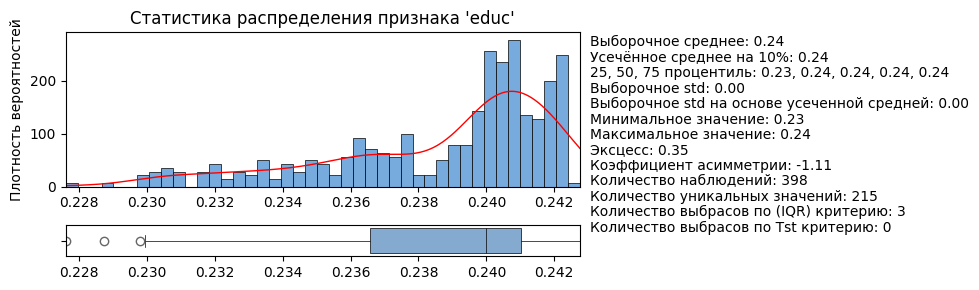

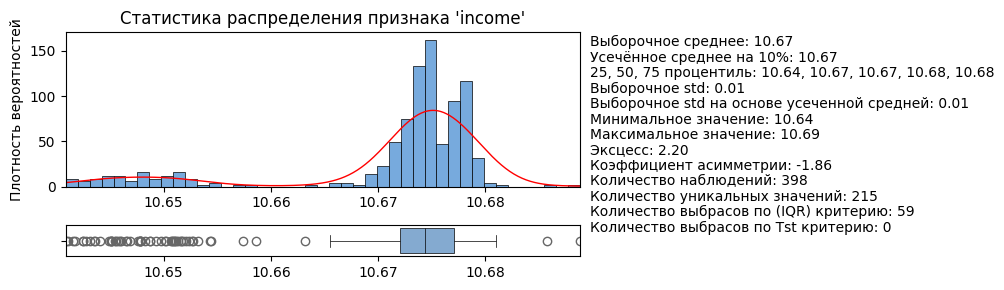

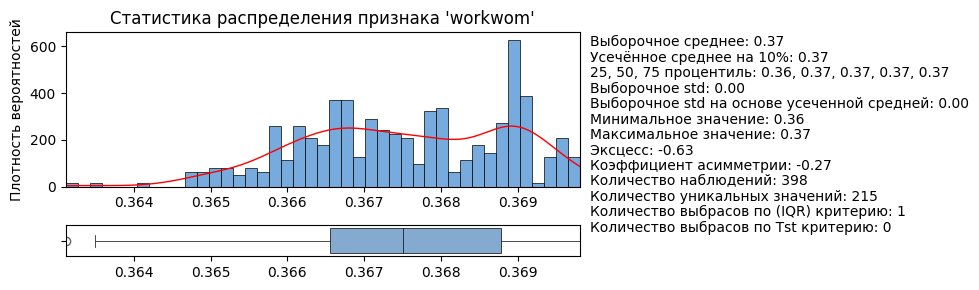

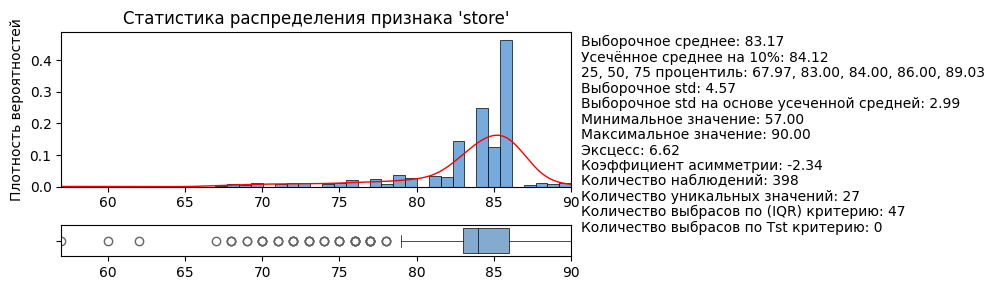

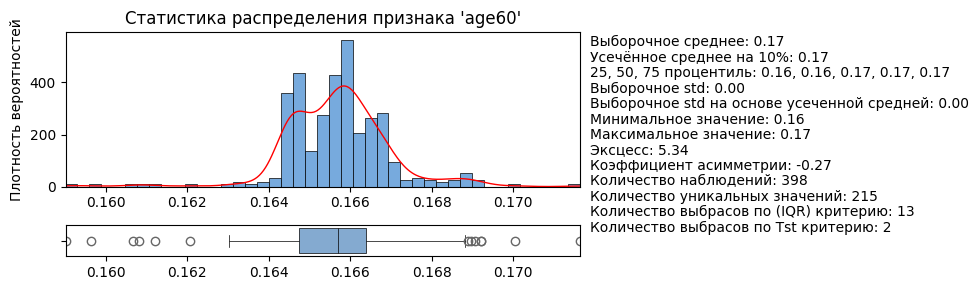

In [6]:
# Исследование cig_sales_dem
# Преобразование категориального признака в бинарные признаки 
cig_sales_dem['sale_B'] = (cig_sales_dem['sale'] == 'B').astype(int)
cig_sales_dem['sale_S'] = (cig_sales_dem['sale'] == 'S').astype(int)
cig_sales_dem['sale_C'] = (cig_sales_dem['sale'] == 'C').astype(int)

# Оставляем более менее информативные фили
cig_sales_dem = cig_sales_dem.drop(columns=['upc','descrip','size','nitem','case','qty'])

# Групируем данные по неделям
cig_sales_weekly = cig_sales_dem.groupby(['week']).agg({'move': 'sum','price': 'mean','age60': 'mean','age9': 'mean','educ': 'mean','ethnic': 'mean','income': 'mean','hhlarge': 'mean',
    'workwom': 'mean','hval150': 'mean','sstrdist': 'mean','sstrvol': 'mean','cpdist5': 'mean','cpwvol5': 'mean', 'sale_B': 'sum', 'sale_S': 'sum', 'sale_C': 'sum', 'store': 'nunique'}).dropna().sort_index()

display(cig_sales_weekly.head())

# Оcновные статистики числовых признаков
num_cols = list(set(cig_sales_weekly.select_dtypes(include=[np.number]).columns))
cig_sales_weekly[num_cols].describe().round(2).transpose().sort_index()

for col in num_cols:
    try:
        bas_stat_num_feat_(df=cig_sales_weekly[col], log=False)
    except:
        pass

move     price     age60      age9      educ    ethnic     income  \
week                                                                       
1     20570  2.146994  0.175473  0.137702  0.217054  0.147291  10.615340   
2     20946  2.203662  0.174678  0.138263  0.215812  0.150654  10.609708   
3     21270  2.164980  0.175383  0.138513  0.210948  0.151815  10.605995   
4     22829  2.180599  0.172904  0.139194  0.210994  0.149714  10.609227   
5     21226  2.113397  0.172991  0.139381  0.211451  0.148146  10.611253   

       hhlarge   workwom   hval150  sstrdist   sstrvol   cpdist5   cpwvol5  \
week                                                                         
1     0.117524  0.356534  0.332531  4.792614  1.149643  2.193887  0.423072   
2     0.117799  0.357118  0.326976  4.969379  1.154362  2.219265  0.419985   
3     0.118610  0.356378  0.319137  4.861940  1.155594  2.221695  0.424715   
4     0.118955  0.357693  0.318906  4.861614  1.155471  2.208977  0.421192   
5     0.119292  0.356732  0.318718  4.817980  1.165340  2.191819  0.419019   

      sale_B  sale_S  sale_C  store  
week                                 
1        977     233       0     68  
2        243       0       0     67  
3        375      67       0     67  
4        440     135       0     69  
5        723     279       0     70

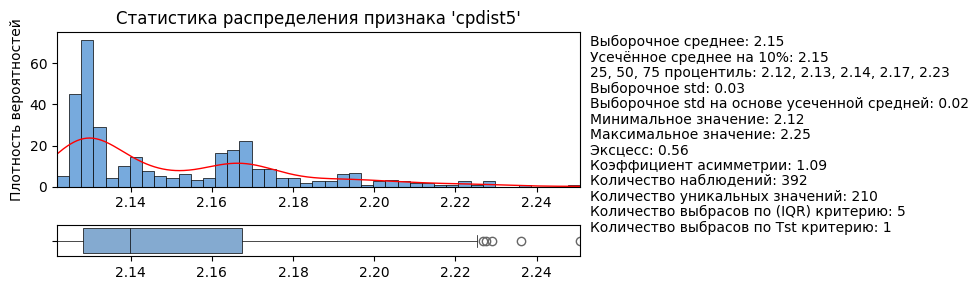

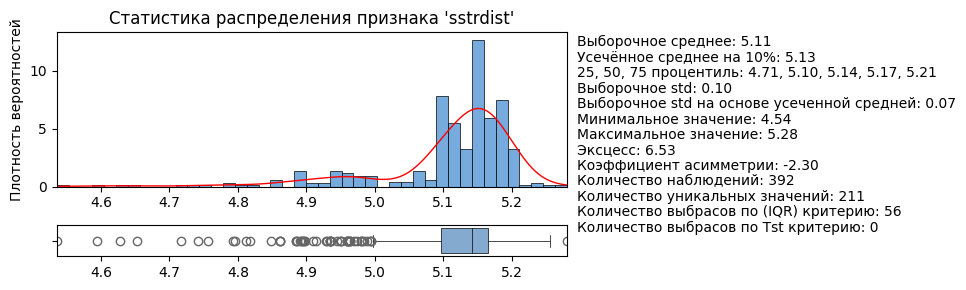

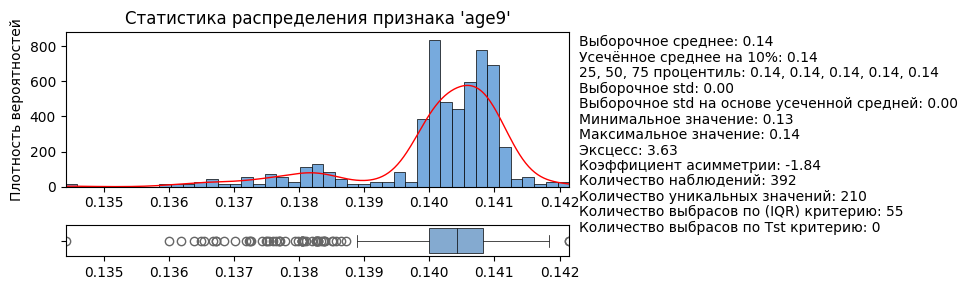

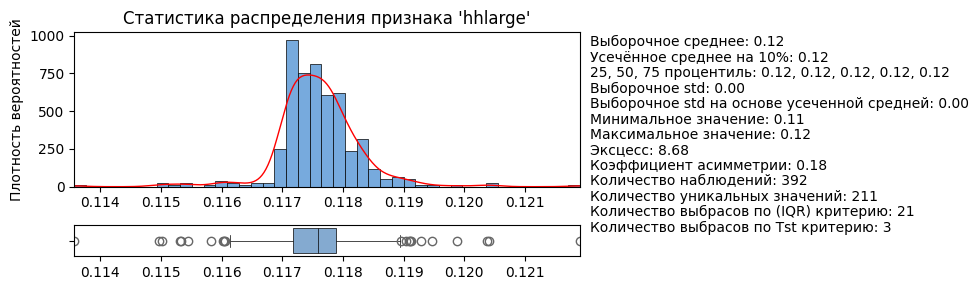

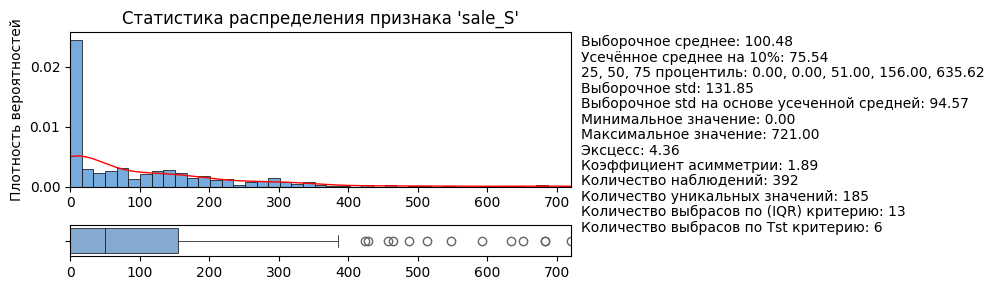

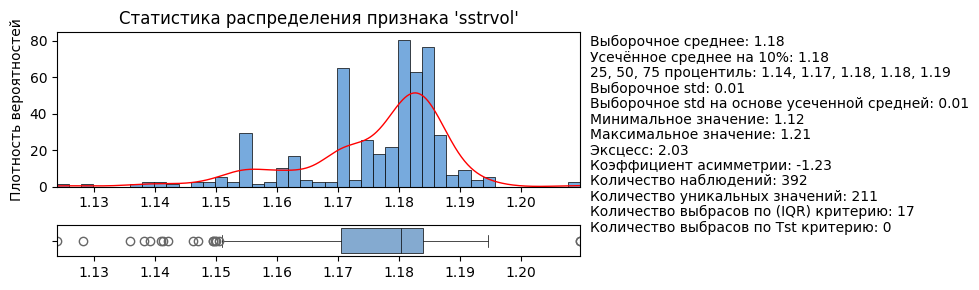

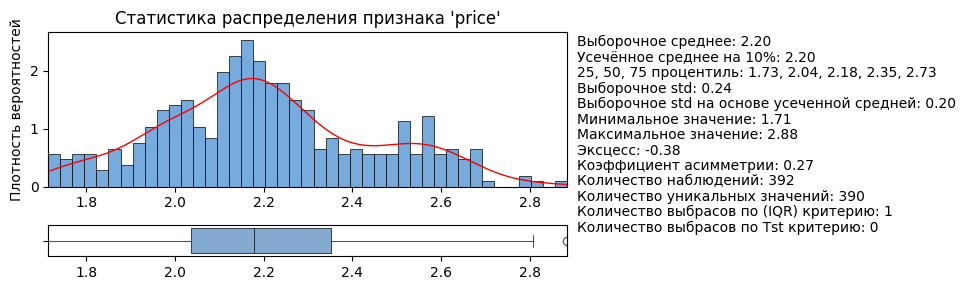

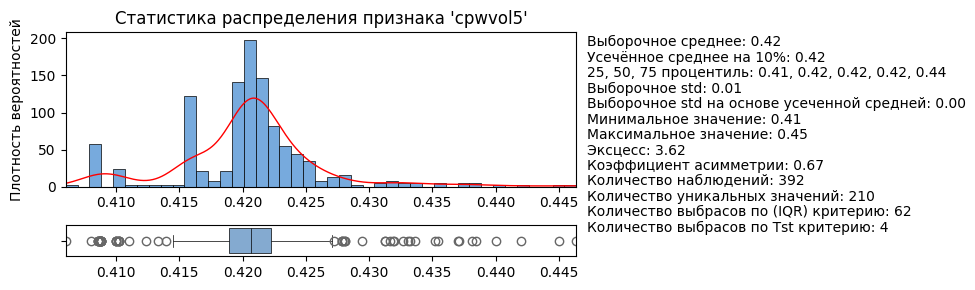

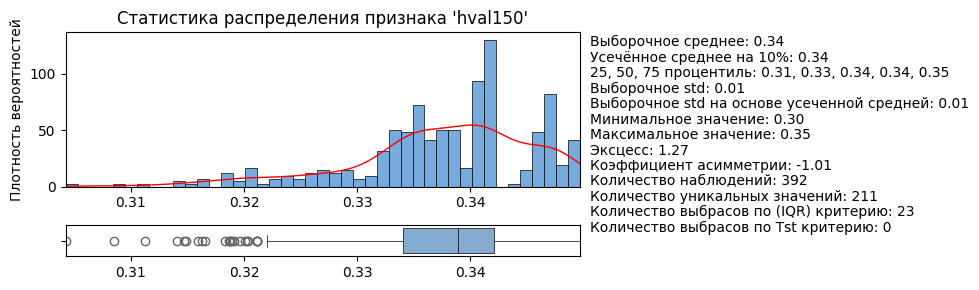

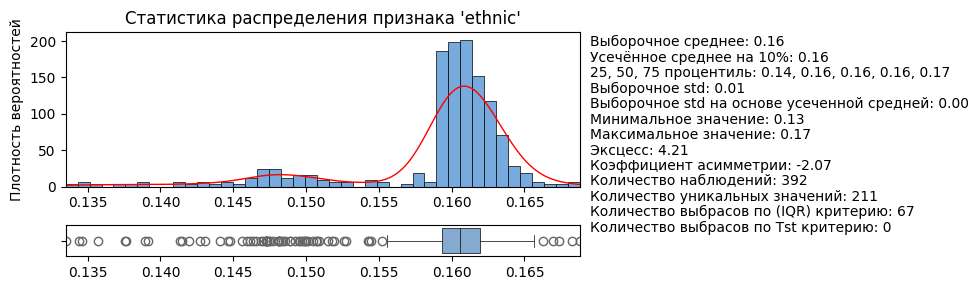

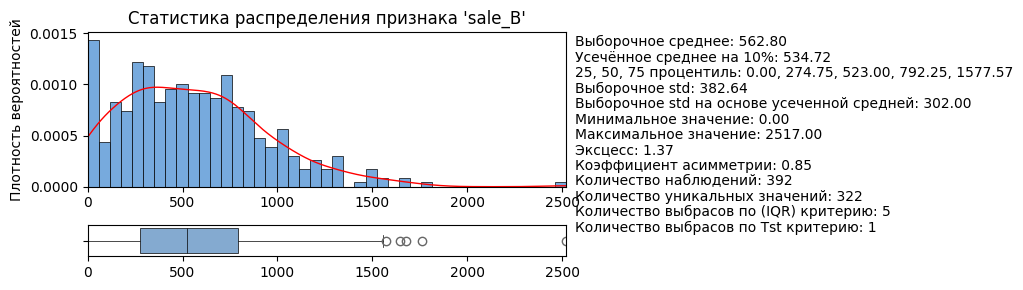

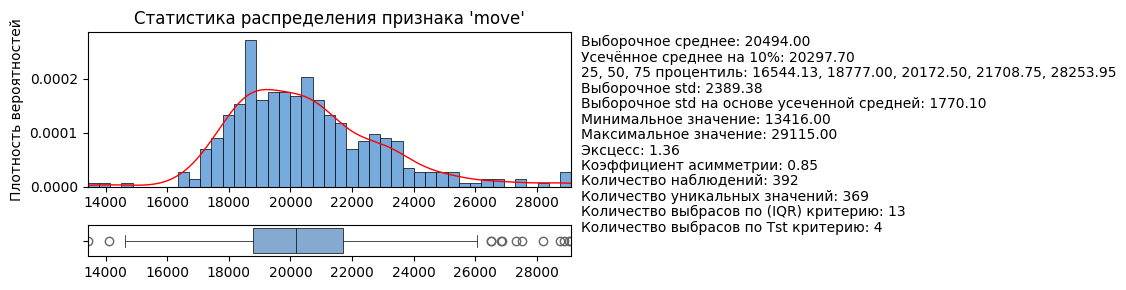

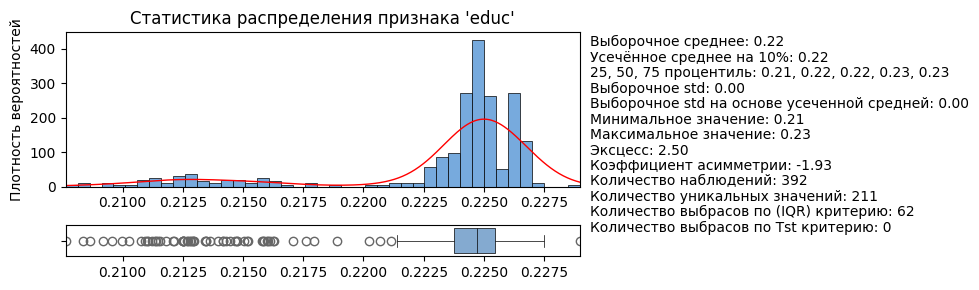

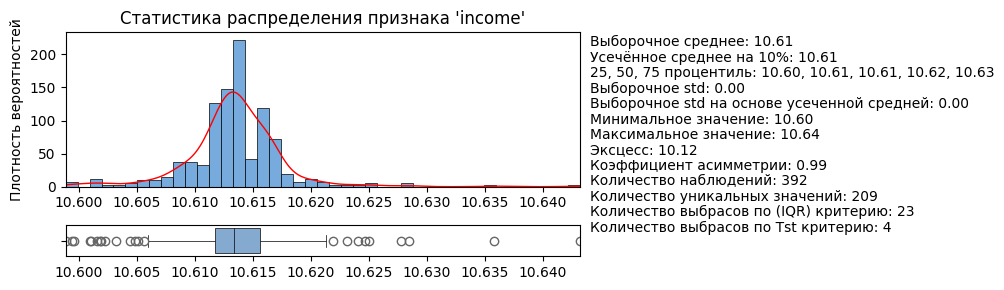

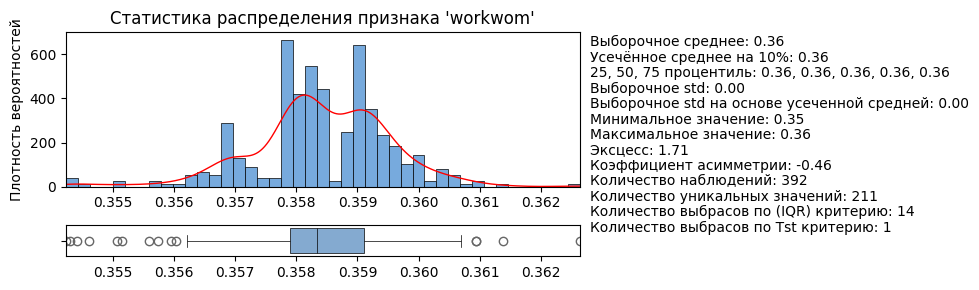

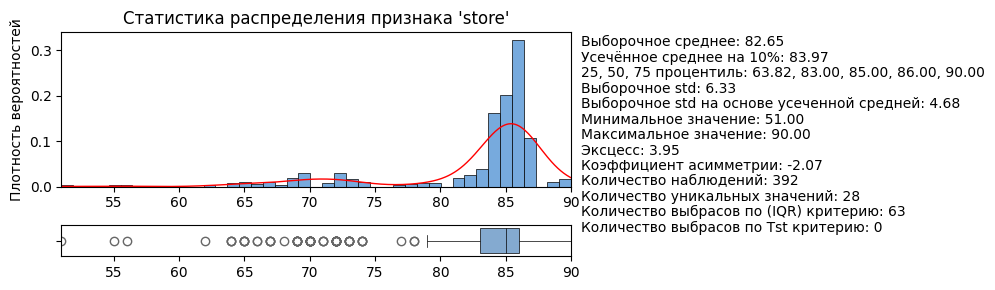

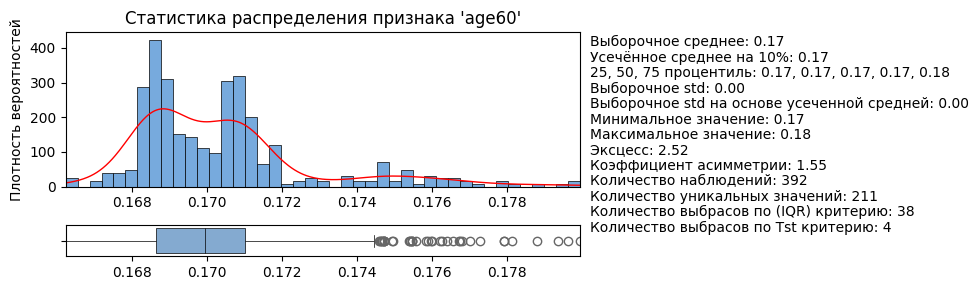

In [7]:
# Исследование ana_sales_dem
# Преобразование категориального признака в бинарные признаки 
ana_sales_dem['sale_B'] = (ana_sales_dem['sale'] == 'B').astype(int)
ana_sales_dem['sale_S'] = (ana_sales_dem['sale'] == 'S').astype(int)
ana_sales_dem['sale_C'] = (ana_sales_dem['sale'] == 'C').astype(int)

# Оставляем более менее информативные фили
ana_sales_dem = ana_sales_dem.drop(columns=['upc','descrip','size','nitem','case','qty'])

# Групируем данные по неделям
ana_sales_weekly = ana_sales_dem.groupby(['week']).agg({'move': 'sum','price': 'mean','age60': 'mean','age9': 'mean','educ': 'mean','ethnic': 'mean','income': 'mean','hhlarge': 'mean',
    'workwom': 'mean','hval150': 'mean','sstrdist': 'mean','sstrvol': 'mean','cpdist5': 'mean','cpwvol5': 'mean', 'sale_B': 'sum', 'sale_S': 'sum', 'sale_C': 'sum', 'store': 'nunique'}).dropna().sort_index()

display(ana_sales_weekly.head())

# Оcновные статистики числовых признаков
num_cols = list(set(ana_sales_weekly.select_dtypes(include=[np.number]).columns))
ana_sales_weekly[num_cols].describe().round(2).transpose().sort_index()

for col in num_cols:
    try:
        bas_stat_num_feat_(df=ana_sales_weekly[col], log=False)
    except:
        pass

In [8]:
# Создание признаков по праздникам
holidays = {
    'Halloween': [7, 59, 112, 164, 216, 268, 320, 372],
    'Thanksgiving': [11, 63, 116, 168, 220, 272, 324, 377],
    'Christmas': [15, 67, 119, 172, 224, 276, 328, 380],
    'New_Year': [16, 68, 120, 173, 225, 277, 329, 381],
    'Presidents_Day': [23, 75, 128, 180, 232, 336, 381],
    'Easter': [28, 81, 123, 185, 238, 289, 341, 393],
    'Memorial_Day': [37, 89, 141, 194, 246, 298, 350],
    '4th_of_July': [42, 95, 147, 199, 251, 303, 356],
    'Labor_Day': [51, 103, 156, 208, 260, 312, 364],

}

for key, val in holidays.items():
    beer_sales_weekly.loc[[ i for i in val if i > 90], key] = 1
    cig_sales_weekly.loc[val, key] = 1
    ana_sales_weekly.loc[val, key] = 1

beer_sales_weekly.fillna(0, inplace=True)
cig_sales_weekly.fillna(0, inplace=True)
ana_sales_weekly.fillna(0, inplace=True)

In [9]:
# Функция для конвертации номера недели в дату
def week_to_date(week_num, start_date):
    start_date = datetime.strptime(start_date, "%m-%d-%y")
    return start_date + timedelta(weeks=week_num-1)

# Применение функции к данным
beer_sales_weekly['date'] = beer_sales_weekly.index.map(lambda x: week_to_date(x, '09-14-89'))
cig_sales_weekly['date'] = cig_sales_weekly.index.map(lambda x: week_to_date(x, '09-14-89'))
ana_sales_weekly['date'] = ana_sales_weekly.index.map(lambda x: week_to_date(x, '09-14-89'))

# Установка даты в качестве индекса
beer_sales_weekly.set_index('date', inplace=True)
cig_sales_weekly.set_index('date', inplace=True)
ana_sales_weekly.set_index('date', inplace=True)

print('Проверка монотонности ряда, для beer_sales_weekly', beer_sales_weekly.index.is_monotonic_increasing)
print('Проверка монотонности ряда, для cig_sales_weekly', cig_sales_weekly.index.is_monotonic_increasing)
print('Проверка монотонности ряда, для ana_sales_weekly', ana_sales_weekly.index.is_monotonic_increasing)

layout = go.Layout(title='Линейный график исторических данных',xaxis=dict(title='Дата'),yaxis=dict(title='Число продаж'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=beer_sales_weekly.index, y=beer_sales_weekly['move'], name='beer_sales'))
fig.add_trace(go.Scatter(x=cig_sales_weekly.index, y=cig_sales_weekly['move'], name='cig_sales'))
fig.add_trace(go.Scatter(x=ana_sales_weekly.index, y=ana_sales_weekly['move'], name='ana_sales'))
fig.show()


Проверка монотонности ряда, для beer_sales_weekly True
Проверка монотонности ряда, для cig_sales_weekly True
Проверка монотонности ряда, для ana_sales_weekly True


В продажах сигарет есть странные пики продаж, начиная с июня 1994 года, а в ряде продаж пива, резкий спад в октябре 1995 годя. В идеале исследовать бы этот момент.

In [10]:
beer_sales_weekly.index = pd.date_range(start=beer_sales_weekly.index[0], periods=len(beer_sales_weekly), freq='W')
cig_sales_weekly.index = pd.date_range(start=cig_sales_weekly.index[0], periods=len(cig_sales_weekly), freq='W')
ana_sales_weekly.index = pd.date_range(start=ana_sales_weekly.index[0], periods=len(ana_sales_weekly), freq='W')

layout = go.Layout(title='Линейный график тренд и сезонной составляющей данных', xaxis=dict(title='Дата'), yaxis=dict(title='Число продаж'))
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(y=seasonal_decompose(beer_sales_weekly['move'], period=52).trend, mode='lines', name='Тренд_beer'))
fig.add_trace(go.Scatter(y=seasonal_decompose(beer_sales_weekly['move'], period=52).seasonal, mode='lines', name='Сезонность_beer'))
fig.add_trace(go.Scatter(y=seasonal_decompose(beer_sales_weekly['move'], period=52).resid, mode='lines', name='Остаток_beer'))

fig.add_trace(go.Scatter(y=seasonal_decompose(cig_sales_weekly['move'], period=52).trend, mode='lines', name='Тренд_cig'))
fig.add_trace(go.Scatter(y=seasonal_decompose(cig_sales_weekly['move'], period=52).seasonal, mode='lines', name='Сезонность_cig'))
fig.add_trace(go.Scatter(y=seasonal_decompose(cig_sales_weekly['move'], period=52).resid, mode='lines', name='Остаток_cig'))

fig.add_trace(go.Scatter(y=seasonal_decompose(ana_sales_weekly['move'], period=52).trend, mode='lines', name='Тренд_ana'))
fig.add_trace(go.Scatter(y=seasonal_decompose(ana_sales_weekly['move'], period=52).seasonal, mode='lines', name='Сезонность_ana'))
fig.add_trace(go.Scatter(y=seasonal_decompose(ana_sales_weekly['move'], period=52).resid, mode='lines', name='Остаток_ana'))

fig.show()


In [11]:
# Проверка стационарности с помощью теста Дики-Фуллера
for df in [beer_sales_weekly, cig_sales_weekly, ana_sales_weekly]:
    result = adfuller(df['move'])
    print('\nADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.829593
p-value: 0.365872
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

ADF Statistic: -1.791305
p-value: 0.384787
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571

ADF Statistic: -4.114420
p-value: 0.000917
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


В сфере реализации анальгетических препаратов наблюдается отсутствие ярко выраженной тенденции, однако отчётливо прослеживается сезонность.

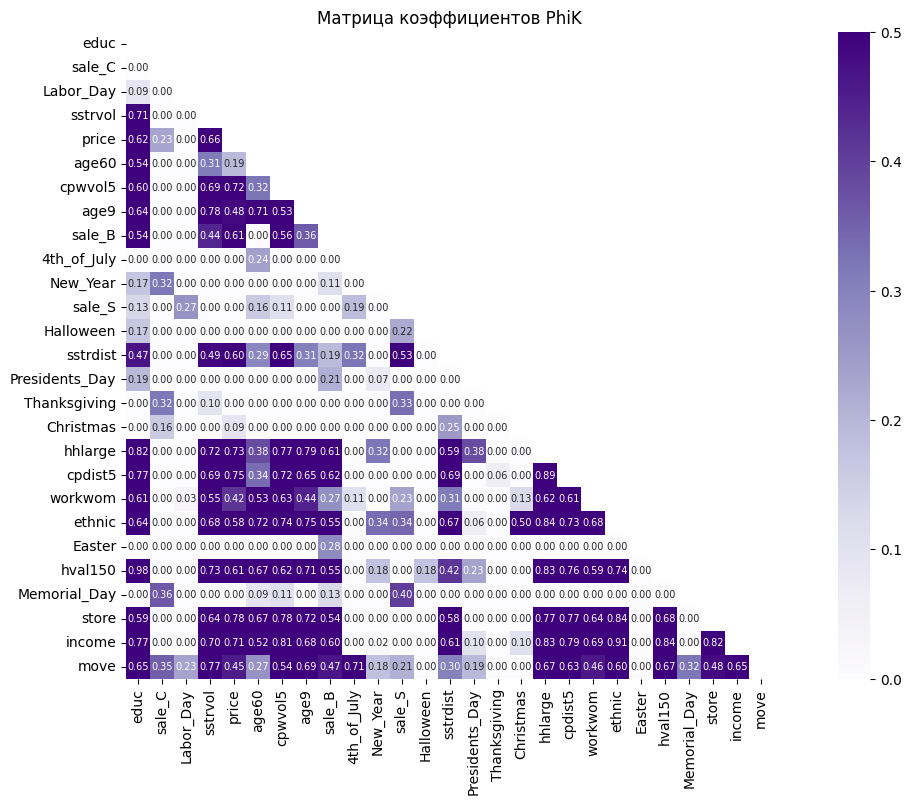

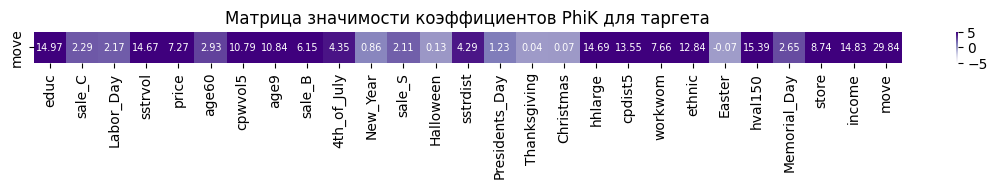

In [19]:
plotting_the_phik_correlation_(df=beer_sales_weekly, feature_num = list(set(beer_sales_weekly.select_dtypes(include=[np.number]).columns) - {'move'}), target='move')

На полученных графиках видно, что целевая переменная `'move'` в данных по продажам пива, практически со всемипризнаками имеет сильную или умеренную значимую корреляцию, за исключением признаков `'age60'` и `'sstrdist'`.

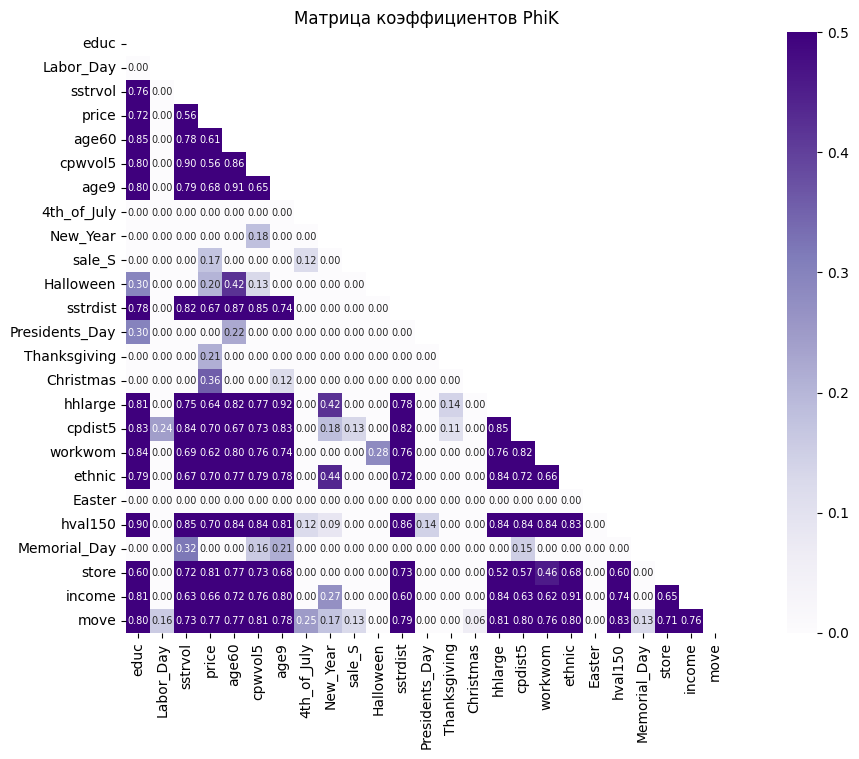

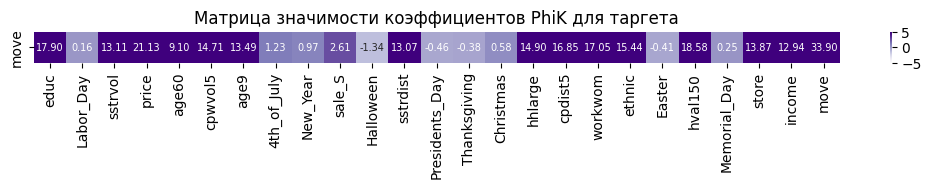

In [21]:
plotting_the_phik_correlation_(df=cig_sales_weekly, feature_num = list(set(cig_sales_weekly.select_dtypes(include=[np.number]).columns) - {'move'} - {'sale_C'} - {'sale_B'}), target='move')

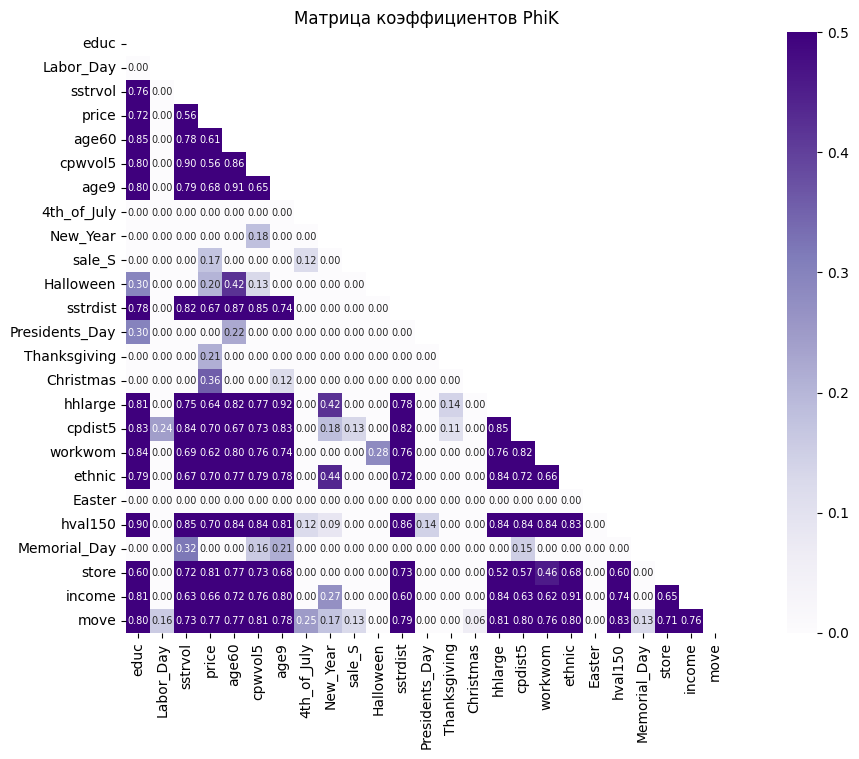

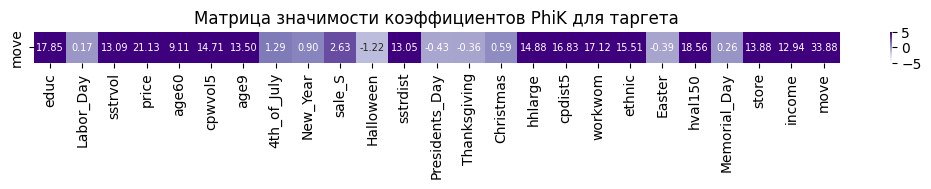

In [22]:
plotting_the_phik_correlation_(df=cig_sales_weekly, feature_num = list(set(cig_sales_weekly.select_dtypes(include=[np.number]).columns) - {'move'} - {'sale_C'} - {'sale_B'}), target='move')

По продажам сигарет и анальгетиков видны очень сильные и умеренные корреляции и значимости между всеми признаками, за исключением праздничных дней.

In [12]:
# Расчет эластичности спроса от цены
def calculate_elasticity(df, price_col, demand_col):
    df['price_change'] = df[price_col].pct_change()
    df['demand_change'] = df[demand_col].pct_change()
    elasticity = df['demand_change'] / df['price_change']
    return elasticity.mean()

# Построение графика зависимости спроса от цены с добавлением скользящего среднего
def plot_demand_price(df, price_col, demand_col, window=13):
    df['moving_avg'] = df[demand_col].rolling(window=window).mean()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df[price_col], y=df[demand_col], mode='markers', name='Demand vs Price'))
    fig.add_trace(go.Scatter(x=df[price_col], y=df['moving_avg'], mode='lines', name='Moving Average', line=dict(color='red')))
    fig.update_layout(
        title='Зависимость спроса от цены',
        xaxis_title='Цена',
        yaxis_title='Спрос',
        template='plotly_white'
    )
    fig.show()

# Пример использования функций
beer_sales_weekly_sorted = beer_sales_weekly.sort_values(by='price')
elasticity = calculate_elasticity(beer_sales_weekly_sorted, 'price', 'move')
print(f'Средняя эластичность спроса от цены: {elasticity:.2f}')
plot_demand_price(beer_sales_weekly_sorted, 'price', 'move')

cig_sales_weekly_sorted = cig_sales_weekly.sort_values(by='price')
elasticity = calculate_elasticity(cig_sales_weekly_sorted, 'price', 'move')
print(f'Средняя эластичность спроса от цены: {elasticity:.2f}')
plot_demand_price(cig_sales_weekly_sorted, 'price', 'move')

ana_sales_weekly_sorted = ana_sales_weekly.sort_values(by='price')
elasticity = calculate_elasticity(ana_sales_weekly_sorted, 'price', 'move')
print(f'Средняя эластичность спроса от цены: {elasticity:.2f}')
plot_demand_price(ana_sales_weekly_sorted, 'price', 'move')


Средняя эластичность спроса от цены: 1201.81


Средняя эластичность спроса от цены: 840.34


Средняя эластичность спроса от цены: -1200.79


Продажи пива и сигарет характеризуются высокой эластичностью спроса, что, вероятно, обусловлено наличием широкого ассортимента альтернативных товаров в других торговых точках. В то же время продажи анальгетиков отличаются низкой эластичностью спроса, что указывает на прямую зависимость объёма спроса от цены на продукт. Это может быть связано с относительно небольшим объёмом производства анальгетиков по сравнению с пивом и сигаретами, а также с особыми условиями хранения и реализации данного товара.

## **2. Обучение моделей**

### 1.1 Исследование бустинговых моделей прогнозирования

Для получения прогнозов решено оставить следующие признаки:
- `'price'` - цена товара напрямую влияет на спрос. Обычно, чем ниже цена, тем выше спрос, и наоборот.
- `'age60'` и `'age9'` - процент населения старше 60 лет и младше 9 лет. Разные возрастные группы могут иметь разные потребности и предпочтения в покупках.
- `'educ'` - процент населения с высшим образованием. Уровень образования может влиять на покупательские привычки и предпочтения.
- `'ethnic'` - процент чернокожих и испаноязычных жителей. Этнический состав населения влияет на спрос так как они связаны с культурными или этническими предпочтениями.
- `'income'` - лгарифм медианного дохода напрямую влияет на покупательскую способность. Чем выше доход, тем больше люди могут тратить на товары.
- `'hhlarge'` - процент домохозяйств с пятью и более членами может влиять на объем покупок. Большие семьи, как правило, покупают больше товаров.
- `'workwom'` - процент работающих женщин с полной занятостью может указывать на уровень занятости и экономическую активность, что влияет на покупательскую способность и предпочтения.
- `'hval150'` - процент домохозяйств с оценочной стоимостью более $150,000 служит индикатором уровня благосостояния.
- `'sstrdist'` - расстояние до ближайшего складского магазина влияет на выбор покупателей, так как они могут предпочитать делать покупки в более удобных местах.
- `'sstrvol'` - соотношение продаж этого магазина к ближайшему складскому магазину указывает на конкурентоспособность магазина и его привлекательность для покупателей.
- `'cpdist5'`- среднее расстояние до ближайших пяти супермаркетов влияет на выбор покупателей и уровень конкуренции.
- `'cpwvol5'` - соотношение продаж этого магазина к среднему уровню продаж ближайших пяти магазинов указывает на конкурентоспособность магазина и его привлекательность для покупателей.

In [13]:
# Приведение ряда к стационарному виду с помощью дифференцирования
beer_sales_weekly['move_diff'] = beer_sales_weekly['move'].diff().dropna()
cig_sales_weekly['move_diff'] = cig_sales_weekly['move'].diff().dropna()

# Выбор признаков
features = beer_sales_weekly.drop(columns=['move_diff', 'move']).columns
target = 'move_diff'

# Разделение данных на тренировочный и тестовый наборы
train_beer, test_beer = train_test_split(beer_sales_weekly.dropna(), test_size=0.25, shuffle=False)
train_cig, test_cig = train_test_split(cig_sales_weekly.dropna(), test_size=0.25, shuffle=False)
train_ana, test_ana = train_test_split(ana_sales_weekly.dropna(), test_size=0.25, shuffle=False)

print(f'От {train_beer.index.min()} до {train_beer.index.max()}, в количестве {len(train_beer)}')
print(f'От {test_beer.index.min()} до {test_beer.index.max()}, в количестве {len(test_beer)}')

print(f'От {train_cig.index.min()} до {train_cig.index.max()}, в количестве {len(train_cig)}')
print(f'От {test_cig.index.min()} до {test_cig.index.max()}, в количестве {len(test_cig)}')

print(f'От {train_ana.index.min()} до {train_ana.index.max()}, в количестве {len(train_ana)}')
print(f'От {test_ana.index.min()} до {test_ana.index.max()}, в количестве {len(test_ana)}')

От 1991-06-16 00:00:00 до 1995-10-01 00:00:00, в количестве 225
От 1995-10-08 00:00:00 до 1997-03-16 00:00:00, в количестве 76
От 1989-09-24 00:00:00 до 1995-05-28 00:00:00, в количестве 297
От 1995-06-04 00:00:00 до 1997-04-27 00:00:00, в количестве 100
От 1989-09-17 00:00:00 до 1995-04-30 00:00:00, в количестве 294
От 1995-05-07 00:00:00 до 1997-03-16 00:00:00, в количестве 98


In [17]:
# Прогнозтрование спроса на пиво
# Подбор оптимальных гиперпараметров на тренировочной части данных с использованием TimeSeriesSplit
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            loss_function = trial.suggest_categorical('loss_function', ['RMSE','MAE','Quantile','LogLinQuantile','MAPE','Poisson'])
            
            model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, eval_metric='MAPE',
                iterations=trial.suggest_int('iterations', 100, 1500, step=10),
                learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1, step=1e-4),
                depth=trial.suggest_int('depth', 1, 6),
                l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.01, 5, step=0.01),
                border_count=trial.suggest_int('border_count', 155, 305, step=5),
                loss_function=loss_function,
            )
            scaler = scaler_dict[trial.suggest_categorical('scaler', ['StandardS','MinMaxS','RobustS','MaxAbsS'])]

            scores = []
            for train_ind, test_ind in TimeSeriesSplit(n_splits=5).split(train_beer):
                cv_train, cv_test = train_beer.iloc[train_ind], train_beer.iloc[test_ind]

                if trial.suggest_categorical('month_cos', [True]):
                    cv_train['month_cos'] = np.cos(2 * np.pi * cv_train.index.month / 12)
                    cv_test['month_cos'] = np.cos(2 * np.pi * cv_test.index.month / 12)

                if trial.suggest_categorical('lag_n', [True]):
                    for lag in range(1, trial.suggest_int('max_lag', 1, 100) + 1, trial.suggest_int('lag_n_interval', 1, 53)):
                        cv_train[f'lag_{lag}'] = cv_train['move_diff'].shift(lag)
                        cv_test[f'lag_{lag}'] = cv_test['move_diff'].shift(lag)

                if trial.suggest_categorical('rolling_mean', [True,False]):
                    cv_train['rolling_mean'] = cv_train['move_diff'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()
                    cv_test['rolling_mean'] = cv_test['move_diff'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()

                cv_train[features] = scaler.fit_transform(cv_train[features]) 
                cv_test[features] = scaler.transform(cv_test[features])

                model.fit(cv_train[features], cv_train[target], eval_set=(cv_test[features], cv_test[target]))
                forecast_diff = model.predict(cv_test[features])

                # Восстановление значений после дифференцирования
                forecast = cv_train['move'].iloc[-1] + forecast_diff.cumsum()

                scores.append(mean_absolute_percentage_error(cv_test['move'], forecast))

            return np.mean(scores) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1)

Trial 45 finished with value: 22.427740865120434 and parameters: {'loss_function': 'MAPE', 'iterations': 1150, 'learning_rate': 0.0184, 'depth': 6, 'l2_leaf_reg': 2.03, 'border_count': 270, 'scaler': 'MinMaxS', 'month_cos': True, 'lag_n': True, 'max_lag': 93, 'lag_n_interval': 4, 'rolling_mean': False}. Best is trial 45 with value: 22.427740865120434.

In [18]:
# Прогнозтрование спроса на пиво
# Тестирование подобранной модели
train_beer_fit, test_beer_fit = train_beer.copy(), test_beer.copy()

train_beer_fit['month_cos'] = np.cos(2 * np.pi * train_beer_fit.index.month / 12)
test_beer_fit['month_cos'] = np.cos(2 * np.pi * test_beer_fit.index.month / 12)

for lag in range(1, 93 + 1, 4):
    train_beer_fit[f'lag_{lag}'] = train_beer_fit['move_diff'].shift(lag)
    test_beer_fit[f'lag_{lag}'] = test_beer_fit['move_diff'].shift(lag)

#train_beer_fit['rolling_mean'] = train_beer_fit['move_diff'].shift().rolling(26).mean()
#test_beer_fit['rolling_mean'] = test_beer_fit['move_diff'].shift().rolling(26).mean()

model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAPE', verbose=0, iterations=1150, learning_rate=0.0184, depth=6, l2_leaf_reg=2.03, border_count=270)
scaler = MinMaxScaler()
train_beer_fit[features] = scaler.fit_transform(train_beer_fit[features]) 
test_beer_fit[features] = scaler.transform(test_beer_fit[features])

model.fit(train_beer_fit[features], train_beer_fit[target])
forecast_diff = model.predict(test_beer_fit[features])

# Восстановление значений после дифференцирования
forecast = train_beer_fit['move'].iloc[-1] + forecast_diff.cumsum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=beer_sales_weekly.index, y=beer_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_beer_fit.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

print(f'MAPE: {mean_absolute_percentage_error(test_beer_fit['move'], forecast):.2%}')

MAPE: 45.14%


In [19]:
# Прогнозтрование спроса на сигареты
# Подбор оптимальных гиперпараметров на тренировочной части данных с использованием TimeSeriesSplit
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            loss_function = trial.suggest_categorical('loss_function', ['RMSE','MAE','Quantile','LogLinQuantile','MAPE','Poisson'])
            
            model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, eval_metric='MAPE',
                iterations=trial.suggest_int('iterations', 100, 1500, step=10),
                learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1, step=1e-4),
                depth=trial.suggest_int('depth', 1, 6),
                l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.01, 5, step=0.01),
                border_count=trial.suggest_int('border_count', 155, 305, step=5),
                loss_function=loss_function,
            )
            scaler = scaler_dict[trial.suggest_categorical('scaler', ['StandardS','MinMaxS','RobustS','MaxAbsS'])]

            scores = []
            for train_ind, test_ind in TimeSeriesSplit(n_splits=5).split(train_cig):
                cv_train, cv_test = train_cig.iloc[train_ind], train_cig.iloc[test_ind]

                if trial.suggest_categorical('month_cos', [True]):
                    cv_train['month_cos'] = np.cos(2 * np.pi * cv_train.index.month / 12)
                    cv_test['month_cos'] = np.cos(2 * np.pi * cv_test.index.month / 12)

                if trial.suggest_categorical('lag_n', [True]):
                    for lag in range(1, trial.suggest_int('max_lag', 1, 100) + 1, trial.suggest_int('lag_n_interval', 1, 53)):
                        cv_train[f'lag_{lag}'] = cv_train['move_diff'].shift(lag)
                        cv_test[f'lag_{lag}'] = cv_test['move_diff'].shift(lag)

                if trial.suggest_categorical('rolling_mean', [True,False]):
                    cv_train['rolling_mean'] = cv_train['move_diff'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()
                    cv_test['rolling_mean'] = cv_test['move_diff'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()

                cv_train[features] = scaler.fit_transform(cv_train[features]) 
                cv_test[features] = scaler.transform(cv_test[features])

                model.fit(cv_train[features], cv_train[target])
                forecast_diff = model.predict(cv_test[features])

                # Восстановление значений после дифференцирования
                forecast = cv_train['move'].iloc[-1] + forecast_diff.cumsum()

                scores.append(mean_absolute_percentage_error(cv_test['move'], forecast))

            return np.mean(scores) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1)

Trial 55 finished with value: 54.16506622054946 and parameters: {'loss_function': 'MAE', 'iterations': 100, 'learning_rate': 0.0064, 'depth': 2, 'l2_leaf_reg': 4.0, 'border_count': 210, 'scaler': 'RobustS', 'month_cos': True, 'lag_n': True, 'max_lag': 8, 'lag_n_interval': 26, 'rolling_mean': True, 'rolling_mean_size': 54}. Best is trial 55 with value: 54.16506622054946.


In [20]:
# Прогнозтрование спроса на сигареты
# Тестирование подобранной модели
train_cig_fit, test_cig_fit = train_cig.copy(), test_cig.copy()

train_cig_fit['month_cos'] = np.cos(2 * np.pi * train_cig_fit.index.month / 12)
test_cig_fit['month_cos'] = np.cos(2 * np.pi * test_cig_fit.index.month / 12)

for lag in range(1, 8 + 1, 26):
    train_cig_fit[f'lag_{lag}'] = train_cig_fit['move_diff'].shift(lag)
    test_cig_fit[f'lag_{lag}'] = test_cig_fit['move_diff'].shift(lag)

train_cig_fit['rolling_mean'] = train_cig_fit['move_diff'].shift().rolling(54).mean()
test_cig_fit['rolling_mean'] = test_cig_fit['move_diff'].shift().rolling(54).mean()

model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', verbose=0, iterations=100, learning_rate=0.0064, depth=2, l2_leaf_reg=4.0, border_count=210)
scaler = RobustScaler()
train_cig_fit[features] = scaler.fit_transform(train_cig_fit[features]) 
test_cig_fit[features] = scaler.transform(test_cig_fit[features])

model.fit(train_cig_fit[features], train_cig_fit[target])
forecast_diff = model.predict(test_cig_fit[features])

# Восстановление значений после дифференцирования
forecast = train_cig_fit['move'].iloc[-1] + forecast_diff.cumsum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=cig_sales_weekly.index, y=cig_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_cig_fit.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

print(f'MAPE: {mean_absolute_percentage_error(test_cig_fit['move'], forecast):.2%}')

MAPE: 25.75%


In [21]:
# Прогнозтрование спроса на анальгетики
# Подбор оптимальных гиперпараметров на тренировочной части данных с использованием TimeSeriesSplit
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            loss_function = trial.suggest_categorical('loss_function', ['RMSE','MAE','Quantile','LogLinQuantile','MAPE','Poisson'])
            
            model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False, eval_metric='MAPE',
                iterations=trial.suggest_int('iterations', 100, 1500, step=10),
                learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1, step=1e-4),
                depth=trial.suggest_int('depth', 1, 6),
                l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 0.01, 5, step=0.01),
                border_count=trial.suggest_int('border_count', 155, 305, step=5),
                loss_function=loss_function,
            )
            scaler = scaler_dict[trial.suggest_categorical('scaler', ['StandardS','MinMaxS','RobustS','MaxAbsS'])]

            scores = []
            for train_ind, test_ind in TimeSeriesSplit(n_splits=5).split(train_ana):
                cv_train, cv_test = train_ana.iloc[train_ind], train_ana.iloc[test_ind]

                if trial.suggest_categorical('month_cos', [True]):
                    cv_train['month_cos'] = np.cos(2 * np.pi * cv_train.index.month / 12)
                    cv_test['month_cos'] = np.cos(2 * np.pi * cv_test.index.month / 12)

                if trial.suggest_categorical('lag_n', [True]):
                    for lag in range(1, trial.suggest_int('max_lag', 1, 100) + 1, trial.suggest_int('lag_n_interval', 1, 53)):
                        cv_train[f'lag_{lag}'] = cv_train['move'].shift(lag)
                        cv_test[f'lag_{lag}'] = cv_test['move'].shift(lag)

                if trial.suggest_categorical('rolling_mean', [True,False]):
                    cv_train['rolling_mean'] = cv_train['move'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()
                    cv_test['rolling_mean'] = cv_test['move'].shift().rolling(trial.suggest_int('rolling_mean_size', 1, 100)).mean()

                cv_train[features] = scaler.fit_transform(cv_train[features]) 
                cv_test[features] = scaler.transform(cv_test[features])

                model.fit(cv_train[features], cv_train['move'])
                forecast_diff = model.predict(cv_test[features])

                scores.append(mean_absolute_percentage_error(cv_test['move'], forecast_diff))

            return np.mean(scores) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1)

[I 2024-12-18 11:54:21,600] Trial 31 finished with value: 7.231042188339452 and parameters: {'loss_function': 'RMSE', 'iterations': 1300, 'learning_rate': 0.044800000000000006, 'depth': 6, 'l2_leaf_reg': 1.77, 'border_count': 225, 'scaler': 'RobustS', 'month_cos': True, 'lag_n': True, 'max_lag': 92, 'lag_n_interval': 33, 'rolling_mean': True, 'rolling_mean_size': 9}. Best is trial 31 with value: 7.231042188339452.

In [22]:
# Прогнозтрование спроса на анальгетики
# Тестирование подобранной модели
train_ana_fit, test_ana_fit = train_ana.copy(), test_ana.copy()

train_ana_fit['month_cos'] = np.cos(2 * np.pi * train_ana_fit.index.month / 12)
test_ana_fit['month_cos'] = np.cos(2 * np.pi * test_ana_fit.index.month / 12)

for lag in range(1, 92 + 1, 33):
    train_ana_fit[f'lag_{lag}'] = train_ana_fit['move'].shift(lag)
    test_ana_fit[f'lag_{lag}'] = test_ana_fit['move'].shift(lag)

train_ana_fit['rolling_mean'] = train_ana_fit['move'].shift().rolling(9).mean()
test_ana_fit['rolling_mean'] = test_ana_fit['move'].shift().rolling(9).mean()

model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='RMSE', verbose=0, iterations=1300, learning_rate=0.0448, depth=6, l2_leaf_reg=1.77, border_count=225)
scaler = RobustScaler()
train_ana_fit[features] = scaler.fit_transform(train_ana_fit[features]) 
test_ana_fit[features] = scaler.transform(test_ana_fit[features])

model.fit(train_ana_fit[features], train_ana_fit['move'])

# Прогнозирование на всю тестовую выборку
forecast_diff = model.predict(test_ana_fit[features])

# Визуализация прогноза с использованием Plotly 
fig = go.Figure()
fig.add_trace(go.Scatter(x=ana_sales_weekly.index, y=ana_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_ana_fit.index, y=forecast_diff, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

# Вывод метрик точности
print(f'MAPE: {mean_absolute_percentage_error(test_ana_fit['move'], forecast_diff):.2%}')

MAPE: 9.94%


Таким образом, анализ данных позволяет сделать вывод о том, что бустинговая модель, применённая для прогнозирования продаж пива, выявила закономерность, связанную со значительным снижением продаж в августе 1995 года. Это, по всей видимости, обусловлено сокращением количества торговых точек. В прогнозе спроса на сигареты в целом верно определена общая тенденция, но не представлены прогнозы относительно пиковых значений. В настоящее время не до конца ясны паттерны прогнозирования, которые могли бы объяснить эти явления. Что касается продаж анальгетиков, то можно сделать вывод о незначительном отклонении от реальных данных. Однако модель не является достаточно убедительной и не отражает сезонные колебания.

### 2. Исследование AutoML

In [23]:
# Использование AutoML для подбора модели для прогнозирования потребления пива
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(train_beer[features], train_beer[target])
forecast_diff = tpot.predict(test_beer[features])

# Восстановление значений после дифференцирования
forecast = train_beer['move'].iloc[-1] + forecast_diff.cumsum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=beer_sales_weekly.index, y=beer_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_beer.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

print(f'MAPE: {mean_absolute_percentage_error(test_beer['move'], forecast):.2%}')


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -134267178.44310343

Generation 2 - Current best internal CV score: -131981208.46293919

Generation 3 - Current best internal CV score: -131981208.46293919

Generation 4 - Current best internal CV score: -130931854.76398146

Generation 5 - Current best internal CV score: -130931854.76398146

Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=7, n_estimators=100)


MAPE: 1169.53%


In [24]:
# Использование AutoML для подбора модели для прогнозирования потребления сигарет
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(train_cig[features], train_cig[target])
forecast_diff = tpot.predict(test_cig[features])

# Восстановление значений после дифференцирования
forecast = train_cig['move'].iloc[-1] + forecast_diff.cumsum()

fig = go.Figure()
fig.add_trace(go.Scatter(x=cig_sales_weekly.index, y=cig_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_cig.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

print(f'MAPE: {mean_absolute_percentage_error(test_cig['move'], forecast):.2%}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -36172425.825595975

Generation 2 - Current best internal CV score: -36172425.825595975

Generation 3 - Current best internal CV score: -36172425.825595975

Generation 4 - Current best internal CV score: -36172425.825595975

Generation 5 - Current best internal CV score: -36172425.825595975

Best pipeline: RidgeCV(MinMaxScaler(MaxAbsScaler(input_matrix)))


MAPE: 31.01%


In [25]:
# Использование AutoML для подбора модели для прогнозирования потребления сигарет
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(train_ana[features], train_ana['move'])
forecast = tpot.predict(test_ana[features])

fig = go.Figure()
fig.add_trace(go.Scatter(x=ana_sales_weekly.index, y=ana_sales_weekly['move'], mode='lines', name='Actual Sales')) 
fig.add_trace(go.Scatter(x=test_ana.index, y=forecast, mode='lines', name='Forecast', line=dict(color='red'))) 
fig.update_layout( title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white' ) 
fig.show()

print(f'MAPE: {mean_absolute_percentage_error(test_ana['move'], forecast):.2%}')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3791185.752854119

Generation 2 - Current best internal CV score: -3791185.752854119

Generation 3 - Current best internal CV score: -3791185.752854119

Generation 4 - Current best internal CV score: -3791185.752854119

Generation 5 - Current best internal CV score: -3791185.752854119

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=3, min_samples_leaf=2, min_samples_split=4)


MAPE: 8.33%


### 3. Исследование фреймворка Prophet

In [26]:
# Прогнозтрование спроса на пиво
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            train_beer_fit, test_beer_fit = train_beer.copy(), test_beer.copy()

            train_beer_fit.reset_index(inplace=True)
            test_beer_fit.reset_index(inplace=True)

            train_beer_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
            test_beer_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

            # Создание и обучение модели Prophet с регрессорами
            model = Prophet(
                growth=trial.suggest_categorical('growth', ['linear','logistic']),
                n_changepoints=trial.suggest_int('n_changepoints', 2, 100),
                changepoint_range=trial.suggest_float('changepoint_range', 0, 1, step=0.01),
                seasonality_mode=trial.suggest_categorical('seasonality_mode', ['additive','multiplicative']),
                seasonality_prior_scale=trial.suggest_float('seasonality_prior_scale', 0.01, 10, step=0.01),
                mcmc_samples=trial.suggest_int('mcmc_samples', 10, 1000),
                interval_width=trial.suggest_float('interval_width', 0, 1, step=0.01),
                uncertainty_samples=trial.suggest_int('uncertainty_samples', 10, 1000),
                scaling=trial.suggest_categorical('scaling', ['absmax','standard']),
            )

            # Добавление регрессоров
            regressors = ['store', 'price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hval150', 'sstrdist', 'sstrvol', 'sale_B', 'sale_S', 'sale_C', 'Thanksgiving', 'Presidents_Day']
            for regressor in regressors:
                model.add_regressor(regressor)

            model.fit(train_beer_fit)

            # Прогнозирование на тестовой выборке
            future = model.make_future_dataframe(periods=len(test_beer_fit), freq='W')
            for regressor in regressors:
                future[regressor] = pd.concat([train_beer_fit[regressor], test_beer_fit[regressor]]).reset_index(drop=True)[-len(future):]

            # Прогнозирование
            forecast = model.predict(future)

            # Вывод метрик точности
            forecast_test = forecast[forecast['ds'].isin(test_beer_fit['ds'])]
            print(f'MAPE: {mean_absolute_percentage_error(test_beer_fit['y'], forecast_test['yhat']):.2%}')

            return mean_absolute_percentage_error(test_beer_fit['y'], forecast_test['yhat']) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=50, timeout=None, n_jobs=1)

Trial 25 finished with value: 31.734904182927547 and parameters: {'growth': 'linear', 'n_changepoints': 58, 'changepoint_range': 0.43, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.76, 'mcmc_samples': 913, 'interval_width': 0.42, 'uncertainty_samples': 600, 'scaling': 'absmax'}

In [27]:
# Подготовка данных для Prophet
train_beer_fit, test_beer_fit = train_beer.copy(), test_beer.copy()

train_beer_fit.reset_index(inplace=True)
test_beer_fit.reset_index(inplace=True)

train_beer_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
test_beer_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

# Создание и обучение модели Prophet с регрессорами
model = Prophet(
    growth='linear',
    n_changepoints=58,
    changepoint_range=0.43,
    seasonality_mode='additive',
    seasonality_prior_scale=7.76,
    mcmc_samples=913,
    interval_width=0.42,
    uncertainty_samples=600,
    scaling='absmax'
)

# Добавление регрессоров
regressors = ['store', 'price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hval150', 'sstrdist', 'sstrvol', 'sale_B', 'sale_S', 'sale_C', 'Thanksgiving', 'Presidents_Day']
for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train_beer_fit)

# Прогнозирование на тестовой выборке
future = model.make_future_dataframe(periods=len(test_beer_fit), freq='W')
for regressor in regressors:
    future[regressor] = pd.concat([train_beer_fit[regressor], test_beer_fit[regressor]]).reset_index(drop=True)[-len(future):]

# Прогнозирование
forecast = model.predict(future)

# Визуализация прогноза с использованием Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_beer_fit['ds'], y=train_beer_fit['y'], mode='lines', name='Actual Sales (Train)'))
fig.add_trace(go.Scatter(x=test_beer_fit['ds'], y=test_beer_fit['y'], mode='lines', name='Actual Sales (Test)'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))
fig.update_layout(title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white')
fig.show()

# Вывод метрик точности
forecast_test = forecast[forecast['ds'].isin(test_beer_fit['ds'])]
print(f'MAPE: {mean_absolute_percentage_error(test_beer_fit['y'], forecast_test['yhat']):.2%}')

13:33:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:33:57 - cmdstanpy - INFO - CmdStan done processing.
13:33:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


MAPE: 32.99%


In [ ]:
# Прогнозтрование спроса на сигареты
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            train_cig_fit, test_cig_fit = train_cig.copy(), test_cig.copy()

            train_cig_fit.reset_index(inplace=True)
            test_cig_fit.reset_index(inplace=True)

            train_cig_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
            test_cig_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

            # Создание и обучение модели Prophet с регрессорами
            model = Prophet(
                growth=trial.suggest_categorical('growth', ['linear','logistic']),
                n_changepoints=trial.suggest_int('n_changepoints', 2, 100),
                changepoint_range=trial.suggest_float('changepoint_range', 0, 1, step=0.01),
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode=trial.suggest_categorical('seasonality_mode', ['additive','multiplicative']),
                seasonality_prior_scale=trial.suggest_float('seasonality_prior_scale', 0.01, 10, step=0.01),
                mcmc_samples=trial.suggest_int('mcmc_samples', 10, 1000),
                interval_width=trial.suggest_float('interval_width', 0, 1, step=0.01),
                uncertainty_samples=trial.suggest_int('uncertainty_samples', 10, 1000),
                scaling=trial.suggest_categorical('scaling', ['absmax','standard']),
            )

            # Добавление регрессоров
            regressors = ['price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge',
                        'workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5',
                        'sale_B', 'sale_S', 'sale_C', 'Halloween', 'Thanksgiving', 'Christmas',
                        'New_Year', 'Presidents_Day', 'Easter', 'Memorial_Day', '4th_of_July',
                        'Labor_Day']
            for regressor in regressors:
                model.add_regressor(regressor)

            model.fit(train_cig_fit)

            # Прогнозирование на тестовой выборке
            future = model.make_future_dataframe(periods=len(test_cig_fit), freq='W')
            for regressor in regressors:
                future[regressor] = pd.concat([train_cig_fit[regressor], test_cig_fit[regressor]]).reset_index(drop=True)[-len(future):]

            # Прогнозирование
            forecast = model.predict(future)

            # Вывод метрик точности
            forecast_test = forecast[forecast['ds'].isin(test_cig_fit['ds'])]
            print(f'MAPE: {mean_absolute_percentage_error(test_cig_fit['y'], forecast_test['yhat']):.2%}')

            return mean_absolute_percentage_error(test_cig_fit['y'], forecast_test['yhat']) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1)

In [31]:
# Подготовка данных для Prophet
train_cig_fit, test_cig_fit = train_cig.copy(), test_cig.copy()

train_cig_fit.reset_index(inplace=True)
test_cig_fit.reset_index(inplace=True)

train_cig_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
test_cig_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

# Создание и обучение модели Prophet с регрессорами
model = Prophet(
    growth='linear',
    n_changepoints=78,
    changepoint_range=0.51,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    seasonality_prior_scale=8.32,
    mcmc_samples=438,
    interval_width=0.28,
    uncertainty_samples=383,
    scaling='absmax'
)

# Добавление регрессоров
regressors = ['price', 'age60', 'age9', 'educ', 'ethnic', 'income', 'hhlarge','workwom', 'hval150', 'sstrdist', 'sstrvol', 'cpdist5', 'cpwvol5', 'sale_B', 
    'sale_S', 'sale_C', 'Halloween', 'Thanksgiving', 'Christmas', 'New_Year', 'Presidents_Day', 'Easter', 'Memorial_Day', '4th_of_July', 'Labor_Day']
for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train_cig_fit)

# Прогнозирование на тестовой выборке
future = model.make_future_dataframe(periods=len(test_cig_fit), freq='W')
for regressor in regressors:
    future[regressor] = pd.concat([train_cig_fit[regressor], test_cig_fit[regressor]]).reset_index(drop=True)[-len(future):]

# Прогнозирование
forecast = model.predict(future)

# Визуализация прогноза с использованием Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_cig_fit['ds'], y=train_cig_fit['y'], mode='lines', name='Actual Sales (Train)'))
fig.add_trace(go.Scatter(x=test_cig_fit['ds'], y=test_cig_fit['y'], mode='lines', name='Actual Sales (Test)'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))
fig.update_layout(title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white')
fig.show()

# Вывод метрик точности
forecast_test = forecast[forecast['ds'].isin(test_cig_fit['ds'])]
print(f'MAPE: {mean_absolute_percentage_error(test_cig_fit['y'], forecast_test['yhat']):.2%}')

13:42:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:42:42 - cmdstanpy - INFO - CmdStan done processing.
13:42:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, colu

MAPE: 28.65%


In [ ]:
# Прогнозтрование спроса на анальгетики
TUNE_HYPERPARAMETERS = False
if TUNE_HYPERPARAMETERS:
    def objective(trial: optuna.Trial):
        try:
            train_ana_fit, test_ana_fit = train_ana.copy(), test_ana.copy()

            train_ana_fit.reset_index(inplace=True)
            test_ana_fit.reset_index(inplace=True)

            train_ana_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
            test_ana_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

            # Создание и обучение модели Prophet с регрессорами
            model = Prophet(
                growth=trial.suggest_categorical('growth', ['linear','logistic']),
                n_changepoints=trial.suggest_int('n_changepoints', 2, 100),
                changepoint_range=trial.suggest_float('changepoint_range', 0, 1, step=0.01),
                seasonality_mode=trial.suggest_categorical('seasonality_mode', ['additive','multiplicative']),
                seasonality_prior_scale=trial.suggest_float('seasonality_prior_scale', 0.01, 10, step=0.01),
                mcmc_samples=trial.suggest_int('mcmc_samples', 10, 1000),
                interval_width=trial.suggest_float('interval_width', 0, 1, step=0.01),
                uncertainty_samples=trial.suggest_int('uncertainty_samples', 10, 1000),
                scaling=trial.suggest_categorical('scaling', ['absmax','standard']),
            )

            # Добавление регрессоров
            regressors = ['store', 'cpwvol5', 'sale_S', 'sale_C', 'Halloween', 'Christmas', 'New_Year', 'Presidents_Day', 'Labor_Day',]
            for regressor in regressors:
                model.add_regressor(regressor)

            model.fit(train_ana_fit)

            # Прогнозирование на тестовой выборке
            future = model.make_future_dataframe(periods=len(test_ana_fit), freq='W')
            for regressor in regressors:
                future[regressor] = pd.concat([train_ana_fit[regressor], test_ana_fit[regressor]]).reset_index(drop=True)[-len(future):]

            # Прогнозирование
            forecast = model.predict(future)

            # Вывод метрик точности
            forecast_test = forecast[forecast['ds'].isin(test_ana_fit['ds'])]
            print(f'MAPE: {mean_absolute_percentage_error(test_ana_fit['y'], forecast_test['yhat']):.2%}')

            return mean_absolute_percentage_error(test_ana_fit['y'], forecast_test['yhat']) * 100
        except:
            raise optuna.TrialPruned()

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=RANDOM_STATE), pruner=SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=40, timeout=None, n_jobs=1)

[I 2024-12-18 14:06:30,750] Trial 24 finished with value: 5.9142505347467464 and parameters: {'growth': 'linear', 'n_changepoints': 171, 'changepoint_range': 0.78, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 8.04, 'mcmc_samples': 435, 'interval_width': 0.8, 'uncertainty_samples': 541, 'scaling': 'absmax'}. Best is trial 24 with value: 5.9142505347467464.

In [14]:
# Подготовка данных для Prophet
train_ana_fit, test_ana_fit = train_ana.copy(), test_ana.copy()

train_ana_fit.reset_index(inplace=True)
test_ana_fit.reset_index(inplace=True)

train_ana_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)
test_ana_fit.rename(columns={'index': 'ds', 'move': 'y'}, inplace=True)

# Создание и обучение модели Prophet с регрессорами
model = Prophet(
    growth='linear',
    n_changepoints=171,
    changepoint_range=0.78,
    seasonality_mode='additive',
    seasonality_prior_scale=8.04,
    mcmc_samples=435,
    interval_width=0.8,
    uncertainty_samples=541,
    scaling='absmax'
)

# Добавление регрессоров
regressors = ['store', 'cpwvol5', 'sale_S', 'sale_C', 'Halloween', 'Christmas', 'New_Year', 'Presidents_Day', 'Labor_Day']
for regressor in regressors:
    model.add_regressor(regressor)

model.fit(train_ana_fit)

# Прогнозирование на тестовой выборке
future = model.make_future_dataframe(periods=len(test_ana_fit), freq='W')
for regressor in regressors:
    future[regressor] = pd.concat([train_ana_fit[regressor], test_ana_fit[regressor]]).reset_index(drop=True)[-len(future):]

# Прогнозирование
forecast = model.predict(future)

# Визуализация прогноза с использованием Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_ana_fit['ds'], y=train_ana_fit['y'], mode='lines', name='Actual Sales (Train)'))
fig.add_trace(go.Scatter(x=test_ana_fit['ds'], y=test_ana_fit['y'], mode='lines', name='Actual Sales (Test)'))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))
fig.update_layout(title='Sales Volume Forecast', xaxis_title='Week', yaxis_title='Sales Volume', legend=dict(x=0, y=1), template='plotly_white')
fig.show()

# Вывод метрик точности
forecast_test = forecast[forecast['ds'].isin(test_ana_fit['ds'])]
print(f'MAPE: {mean_absolute_percentage_error(test_ana_fit['y'], forecast_test['yhat']):.2%}')

14:10:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:10:36 - cmdstanpy - INFO - CmdStan done processing.
14:10:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Except

MAPE: 5.94%


## 3. Выводы.

- В рамках исследования был проведён анализ временного ряда с целью прогнозирования спроса на основе исторических данных для трёх категорий товаров: пиво, сигареты и анальгетики.

- В рамках подхода прогнозирования с использованием моделей класического ML наилучшие результаты на безлойновых запусках показали линейные модели и CatBoostRegressor, но приоритет остался за бустингом. Таким образом, анализ данных  применённый для прогнозирования продаж пива, выявила закономерность, связанную со значительным снижением продаж в августе 1995 года. Это, по всей видимости, обусловлено сокращением количества торговых точек. В прогнозе спроса на сигареты в целом верно определена общая тенденция, но не представлены прогнозы относительно пиковых значений. В настоящее время не до конца ясны паттерны прогнозирования, которые могли бы объяснить эти явления. Что касается продаж анальгетиков, то можно сделать вывод о незначительном отклонении от реальных данных. Однако модель не является достаточно убедительной и не отражает сезонные колебания. Таким образом средние абсолютные процентные ошибки иследуеммых рядов по отложенной выборке составили:
    - продажи пива - MAPE 45.1%
    - продажи сигарет - MAPE 25.8%
    - продажи анальгетиков - MAPE 9.9%

- В рамках подхода прогнозирования с использованием AutoML фреймворка TPOTRegressor получены следующие результаты:
    - продажи пива - модель ExtraTreesRegressor - MAPE 1169%
    - продажи сигарет - RidgeCV - MAPE 31%
    - продажи анальгетиков - DecisionTreeRegressor - MAPE 8.33%
    Метрики и качество прогнозирования продаж пива и сигарет, модели, выбранные с использованием AutoML, демонстрируют неудовлетворительные результаты. В случае с продажами анальгетиков, несмотря на более высокую метрику, точность прогнозирования остаётся недостаточной, а сезонность не определена вовсе.

- В рамках подхода прогнозирования с использованием фреймворка Prophet получены следующие результаты, которые являются наиболее точными:
    - продажи пива - MAPE 38.8%. Признаки, которые оказывают наибольшее влияние на прогнозирование продаж: `'store'`, `'price'`, `'age60'`, `'age9'`, `'educ'`, `'ethnic'`, `'income'`, `'hval150'`, `'sstrdist'`, `'sstrvol'`, `'sale_B'`, `'sale_S'`, `'sale_C'`, `'Thanksgiving'`, `'Presidents_Day'`.
    - продажи сигарет - MAPE 28.7% - на данный момент выявить патерны, ответственные за резкие пики продаж, выявить не успел, требуется провести больше аналитики.
    - продажи анальгетиков - MAPE 5.9%. Признаки, которые оказывают наибольшее влияние на прогнозирование продаж: `'store'`, `'cpwvol5'`, `'sale_S'`, `'sale_C'`, `'Halloween'`, `'Christmas'`, `'New_Year'`, `'Presidents_Day'`, `'Labor_Day'`, однако множество пиковых значений не было  спрогнозированно, требуется провести больше аналитики.